# Spike Time Dependent Plasticity
## Basic Experiments

In this notebook I'm going to implement some basic experiments related to the STDP algorithm from scratch.

The outline for this notebook is the following:
- Prelimainaries
    - Generic function for simulations
    - Default parameters
    - Plot utils
- Simple neurons models:
    - LIF neuron 
    - Poisson Neuron Model
- STDP algorithms
    - general simulation
    - STDP rule
- Turn the screw on STDP
    - ...
    - ...

In [10]:
%load_ext autoreload
%autoreload 2
# basic libraries
import os
import sys
import shutil
import time
import numpy as np
import pandas as pd

# graphics libraries
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format='retina'
# use NMA plot style
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
plt.style.use('seaborn-v0_8')
my_layout = widgets.Layout()
my_layout.width = '620px'

#import from my scripts
main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)
import importlib

importlib.reload(importlib.import_module('neurons'))
importlib.reload(importlib.import_module('learning_rules'))
from neurons import *
from learning_rules import *

# show packages versions for python, numpy, and ipywidgets
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)
print("IPywidgets: ", widgets.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Numpy:  1.25.2
Pandas:  2.1.1
IPywidgets:  8.0.4


# Framework 

## Simulations on simple networks

I start by writing a function to study a given neuron type and a given weight update rule. I'm working with a network with `N_pre` presynaptic neuron (whose spike trains are controlled) and 1 post synaptic neuron.

In [11]:
def base_simulation(
        pars,
        spk_input, # input spike train, a numpy vector of shape (time_steps, N_pre)
        neuron_type, # class for the neuron type
        weight_rule = None, # class for the weights update
        N_pre = 100, # number of pre-synaptic neurons
        W_init = None, # initial weights
        neuron_params = {}, # parameters for the neuron model
        weight_update_params = {}, # parameters for the weight update
):
    N_post = 1 # this is the base simulation, just one output neuron
    num_steps = np.shape(spk_input)[0]

    # Initialize the weights
    my_neuron = neuron_type(pars, **neuron_params)
    

    # Check if the given inital weight are valid
    if W_init is None:
        W_init = np.random.rand(N_post, N_pre)
    else:
        assert np.shape(W_init)[1] == N_pre, 'W must have the same number of rows as the number of pre-synaptic neurons'

    # Initialize the synapses with the given update rule
    if weight_rule is not None:
        my_synapses = weight_rule(pars, N_pre, N_post, W_init = W_init,**weight_update_params)
    else:
        W = W_init 

    # start the simulation
    for t in range(num_steps):
        
        # get the spikes from the pre-synaptic neurons at time t
        pre_syn_spikes = spk_input[t,:] 
        # get the weights from the synapse
        if weight_rule is not None:
            W = my_synapses.W
        
        # compute the input current for the postsynaptic neuron
        #I = np.dot(pre_syn_spikes, W[:,0])
        I = (W @ pre_syn_spikes)[0]

        # run the neuron model
        _ , spk = my_neuron.forward(I)

        # update the weights
        if weight_rule is not None:
            spikes = [pre_syn_spikes, spk]
            my_synapses.update_weights(spikes)

    if weight_rule is not None:
        return my_neuron, my_synapses
    else:
        return my_neuron


This function generalizes the previous one allowing for multiple postsynaptic neurons `N_post`. In additions it also include the presynaptic layer explicitely.

In [12]:
def FC_simulation(
        pars,
        N_pre,
        N_post,
        I_inj, # input spike train, a numpy vector of shape (time_steps, N_pre)
        neuron_type, # function for the type of neuron 
        weight_update = None, # function for the weight update
        W_init = None, # initial weights
        neuron_params = {}, # parameters for the neuron model
        weight_update_params = {}, # parameters for the weight update
):
    
    num_steps = np.shape(I_inj)[0]

    # Initialize the arrays for spikes, membrane potential and weights recording
    pre_spk_train = np.zeros((num_steps, N_pre)) 
    post_spk_train = np.zeros((num_steps, N_post))
    pre_mem_record = np.zeros((num_steps, N_pre))
    post_mem_record = np.zeros((num_steps, N_post))
    I_post_inj = np.zeros((num_steps, N_post))
    weights_history = np.zeros((num_steps+1, N_post, N_pre))


    # Initialize the weights
    if W_init is None:
        W_init = np.random.rand(N_post,N_pre)
    else:
        assert np.shape(W_init) == (N_post,N_pre), 'W must have the shape (N_post, N_pre)'

    weights_history[0,:,:] = W_init

    # initialize some 
    traces = None
    W = W_init

    # start the simulation
    for t in range(num_steps):

        # pass the injected current to the pre_synaptic neurons
        for j in range(N_pre):
            if t>1:
                pre_mem, pre_spk = neuron_type(pars, I_inj[t,j], mem = pre_mem_record[t-1,j], **neuron_params)
            else:
                pre_mem, pre_spk = neuron_type(pars, I_inj[t,j], **neuron_params)
            pre_spk_train[t,j] = pre_spk
            pre_mem_record[t,j] = pre_mem

        # compute the input current for the post-synaptic neurons
        I_post = W @ pre_spk_train[t,:] # spikes from the pre-synaptic neurons at time t
        #print(I_post)
        I_post_inj[t,:] = I_post

        # pass the current to the post-synaptic neurons
        for i in range(N_post):
            if t>1:
                post_mem, post_spk = neuron_type(pars, I_post[i], mem = post_mem_record[t-1,i], **neuron_params)
            else:
                post_mem, post_spk = neuron_type(pars, I_post[i], **neuron_params)
            post_spk_train[t,i] = post_spk
            post_mem_record[t,i] = post_mem


        # update the weights
        if weight_update is not None:
            spikes = [pre_spk_train[t,:], post_spk_train[t,:]]
            W, traces = weight_update(pars, W, traces, spikes, **weight_update_params)
        else:
            W = W

        # store the weights
        weights_history[t+1,:,:] = W

    return weights_history, pre_spk_train, post_spk_train, pre_mem_record, post_mem_record, I_post_inj



## Default parameters for the models

These are the parameters coming from neuroscience studies.

In [13]:
def default_pars(**kwargs):
    '''
    Define the default parameters
    values come from COURSE 2 
    '''

    pars = {}

    # typical neuron parameters
    pars['threshold'] = -55.    # spike threshold [mV]
    pars['tau_m'] = 10.         # membrane time constant [ms]
    pars['R'] = 0.1             # leak resistance [Ohm] with this resistance input current must be of the order of 100 mV
    pars['U_init'] = -65.       # initial potential [mV]
    pars['U_reset'] = -75.      # reset potential [mV]
    pars['U_resting'] = -75.    # leak reversal potential [mV]
    pars['t_ref'] = 5.          # refractory time (ms)

    # in the case of dynamic threshold
    pars['tau_thr'] = 20        # threshold time constant [ms]
    pars['ratio_thr'] = 1.1     # relative increment in the threshold due to a spike

    # in the case of soft reset
    ## ?? some way to lower the membrane potential not to a constant value
    
    # in case of noisy input
    pars['sigma'] = 1         # standard deviation of the noise

    # random seed
    pars['my_seed'] = 42

    # time steps
    pars['dt'] = 0.1             # simulation time step [ms]

    # for Poisson models
    pars['alpha'] = 0.1          # scaling factor for the membrane to the rate

    # STDP parameters
    pars['A_plus'] = 0.8                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD 
    pars['tau_plus'] = 20                    # LTP time constant [ms]
    pars['tau_minus'] = pars['tau_plus']     # LTD time constant [ms]

    # weight parameters
    pars['w_max'] = 1.            # maximum weight
    pars['w_min'] = 0.            # minimum weight


    # external parameters if any #
    for k in kwargs:
        pars[k] = kwargs[k]

    return pars


pars = default_pars()

These are the parameters we hope to use.

In [14]:
def simple_pars(**kwargs):
    '''
    Define the default parameters
    values come from COURSE 2 
    '''

    pars = {}

    # typical neuron parameters
    pars['threshold'] = 1.    # spike threshold [mV]
    pars['tau_m'] = 10.         # membrane time constant [ms]
    pars['R'] = 1            # leak resistance [Ohm] with this resistance input current must be of the order of 100 mV
    pars['U_init'] = 0       # initial potential [mV]
    pars['U_reset'] = 0.      # reset potential [mV]
    pars['U_resting'] = 0.    # leak reversal potential [mV]
    pars['t_ref'] = 2.          # refractory time (ms)

    # in the case of dynamic threshold
    pars['tau_thr'] = 20         # threshold time constant [ms]
    pars['ratio_thr'] = 1.1     # relative increment in the threshold due to a spike

    # in the case of soft reset
    ## ?? some way to lower the membrane potential not to a constant value

    # random seed
    pars['my_seed'] = 42

    # time steps
    pars['dt'] = 1             # simulation time step [ms]

    # for Poisson models
    pars['alpha'] = 0.1          # scaling factor for the membrane to the rate

    # STDP parameters
    pars['A_plus'] = 0.008                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD 
    pars['tau_plus'] = 20                    # LTP time constant [ms]
    pars['tau_minus'] = pars['tau_plus']     # LTD time constant [ms]

    # weight parameters
    pars['w_max'] = 1.            # maximum weight
    pars['w_min'] = 0.            # minimum weight


    # external parameters if any #
    for k in kwargs:
        pars[k] = kwargs[k]

    return pars

s_pars = simple_pars()

## Plot utilis

Here I group the functions to plot the graphics/interactive demos given a simulation.

First a basic raster plot for the input and output neurons.


In [15]:
# we are plotting the case in which we have the input spikes equal to the injected current
def raster_plot(
        pars, # parameters
        pre_syn_spk, # input spikes as array of 0,1 of shape (time_steps, N_pre) or as list of spike times
        post_syn_spk, # output spikes as array of 0,1 of shape (time_steps, N_post) or as list of spike times
        title = 'Raster plot',
        time_in_ms = False):
    
    """
    function to plot the raster plot of the input and output spikes
    INPUTS:
    - pars: parameters of the simulation
    - pre_syn_spk: input spikes as array of 0,1 of shape (time_steps, N_pre) or as list of spike times
    - post_syn_spk: output spikes as array of 0,1 of shape (time_steps, N_post) or as list of spike times
    - title: title of the plot
    """

    if time_in_ms:
        dt=pars['dt']
        label_x = 'Time (ms)'
    else:
        dt=1
        label_x = 'Time steps'

    # useful values
    N_pre = np.shape(pre_syn_spk)[1]
    if np.ndim(post_syn_spk) == 1:
        N_post = 1
        post_syn_spk = np.expand_dims(post_syn_spk, axis=1)
    else:
        N_post = np.shape(post_syn_spk)[1]
    time_steps = np.shape(pre_syn_spk)[0]

    # Generate Plots
    height_ratio = int(min(N_pre/ N_post,10))
    fig, ax = plt.subplots(2, figsize=(15,10), sharex=True, gridspec_kw = {'height_ratios': [height_ratio,1]})


    # convert spike record in spike times
    if type(pre_syn_spk) is list:
        pre_syn_spk_times = pre_syn_spk
    else:
        # note: even with 10000 presynaptic neurons and 10000 time steps this is not an heavy operation
        pre_syn_spk_times = [np.array(np.where(pre_syn_spk[:,i]==1)[0])*dt for i in range(N_pre)]
        
    ax[0].eventplot(pre_syn_spk_times, colors='black', lineoffsets=1,linewidth=1, linelengths=0.8, orientation='horizontal')
    # set y axis ticks corresponding to the neurons
    ax[0].set_yticks(np.arange(0, len(pre_syn_spk_times)+1, round(N_pre/10)))
    ax[0].set_ylabel("Input Spikes")
    ax[0].set_title(title)


    # Plot output spikes
    if type(post_syn_spk) is list:
        post_syn_spk_times = post_syn_spk
    else:
        post_syn_spk_times = [np.array(np.where(post_syn_spk[:,i]==1)[0])*dt for i in range(N_post)]
    ax[1].eventplot(post_syn_spk_times, colors='black', lineoffsets=1,linewidth=1, linelengths=0.8, orientation='horizontal')   
    ax[1].set_yticks(np.arange(0, N_post, max(round(N_post/10),1)))
    ax[1].set_ylabel("Output Spikes")
    ax[1].set_xlabel(label_x)

    plt.show()

Plot the weigths history.

In [16]:
def weights_plot(pars, weights_history,time_step = None, time_in_ms = False):
    """
    Plot the weights changes during the simulation

    INPUT:
    - pars: parameter dictionary
    - weights_history: synaptic weights over time for one post_synaptic neuron
    - spk_out: spike train of the post-synaptic neuron

    RETURN:
    Interactive demo, Visualization of synaptic weights
    """

    # check if we want the time in ms
    if time_in_ms:
        dt=pars['dt']
        label_x = 'Time (ms)'
    else:
        dt=1
        label_x = 'Time steps'

    # useful values
    N_pre = weights_history.shape[1]
    num_steps = weights_history.shape[0]
    time_steps = np.arange(0, num_steps, 1)*dt

    # set the default time step
    if time_step is None:
        time_step = num_steps-10
    elif time_step > num_steps:
        print(f'Time step must be less than {num_steps}')
        return
    
    subsampling = 1

    fig,ax = plt.subplots(3, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 2, 1]})#, sharex=True)

    fig.colorbar(ax[0].imshow(weights_history[:,:].T, cmap = 'viridis', aspect='auto'), ax=ax[0], orientation='vertical', fraction = 0.01, pad = 0.01)
    ax[0].set_xlabel(label_x)
    ax[0].axvline(time_step, 0., 1., color='red', ls='--')
    # remove the background grid
    ax[0].grid(False)
    ax[0].set_ylabel('Synaptic weights')
    

    ax[1].plot(time_steps[::subsampling], weights_history[ ::subsampling,:], lw=1., alpha=0.7)
    ax[1].axvline(time_step, 0., 1., color='red', ls='--')
    ax[1].set_xlabel(label_x)
    ax[1].set_ylabel('Weight')

    w_min = np.min(weights_history[time_step,:])-0.1
    w_max = np.max(weights_history[time_step,:])+0.1
    width = (w_max - w_min)/51
    bins = np.arange(w_min, w_max, width)
    #g_dis, _ = np.histogram(weights_history[time_step,:], bins)
    #ax[1].bar(bins[1:], g_dis, color='b', alpha=0.5, width=width)
    ax[2].hist(weights_history[time_step,:], bins, color='b', alpha=0.5, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
    ax[2].set_xlabel('weights ditribution')
    ax[2].set_ylabel('Number')
    ax[2].set_title(f'Time step: {time_step}')
    plt.tight_layout()
    plt.show()
    

In [25]:
import matplotlib
matplotlib.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [56]:
weights_history = syn.get_records()['W']
pre_trace_record = syn.get_records()['pre_trace']
post_trace_record = syn.get_records()['post_trace']
time_steps = np.arange(0, len(weights_history), 1)
# print the shapes
print(np.shape(weights_history))
print(np.shape(pre_trace_record))
print(np.shape(post_trace_record))

(1001, 1, 300)
(1000, 300)
(1000, 1)


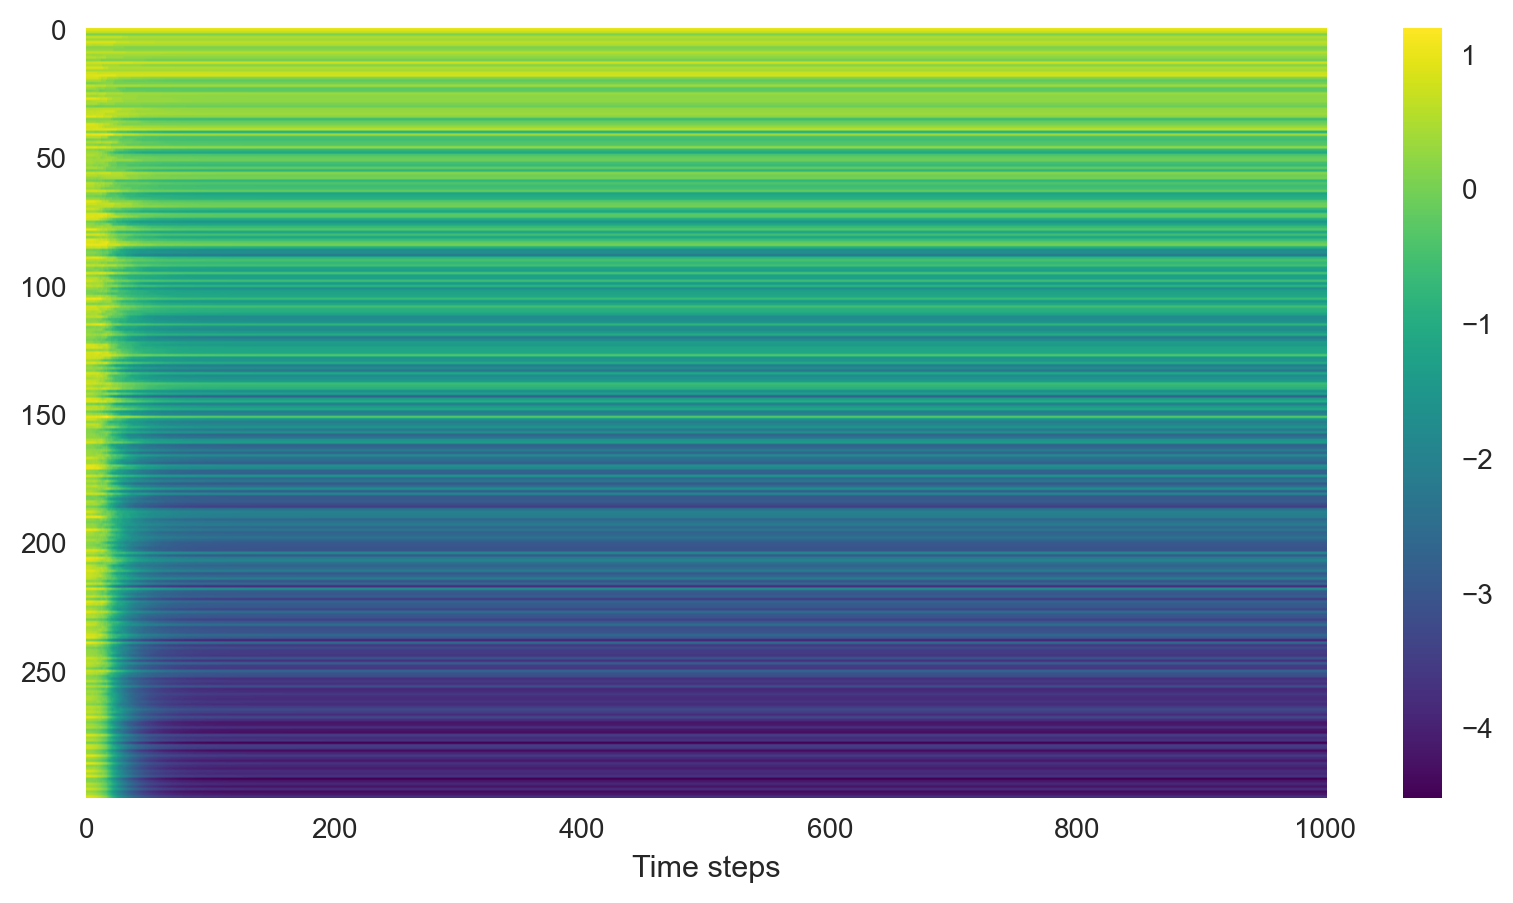

In [57]:
plt.figure(figsize=(10, 5))
plt.imshow(weights_history[:,0,:].T, cmap = 'viridis', aspect='auto')
plt.xlabel('Time steps')
# remove the background grid
plt.grid(False)
plt.colorbar()
plt.show()

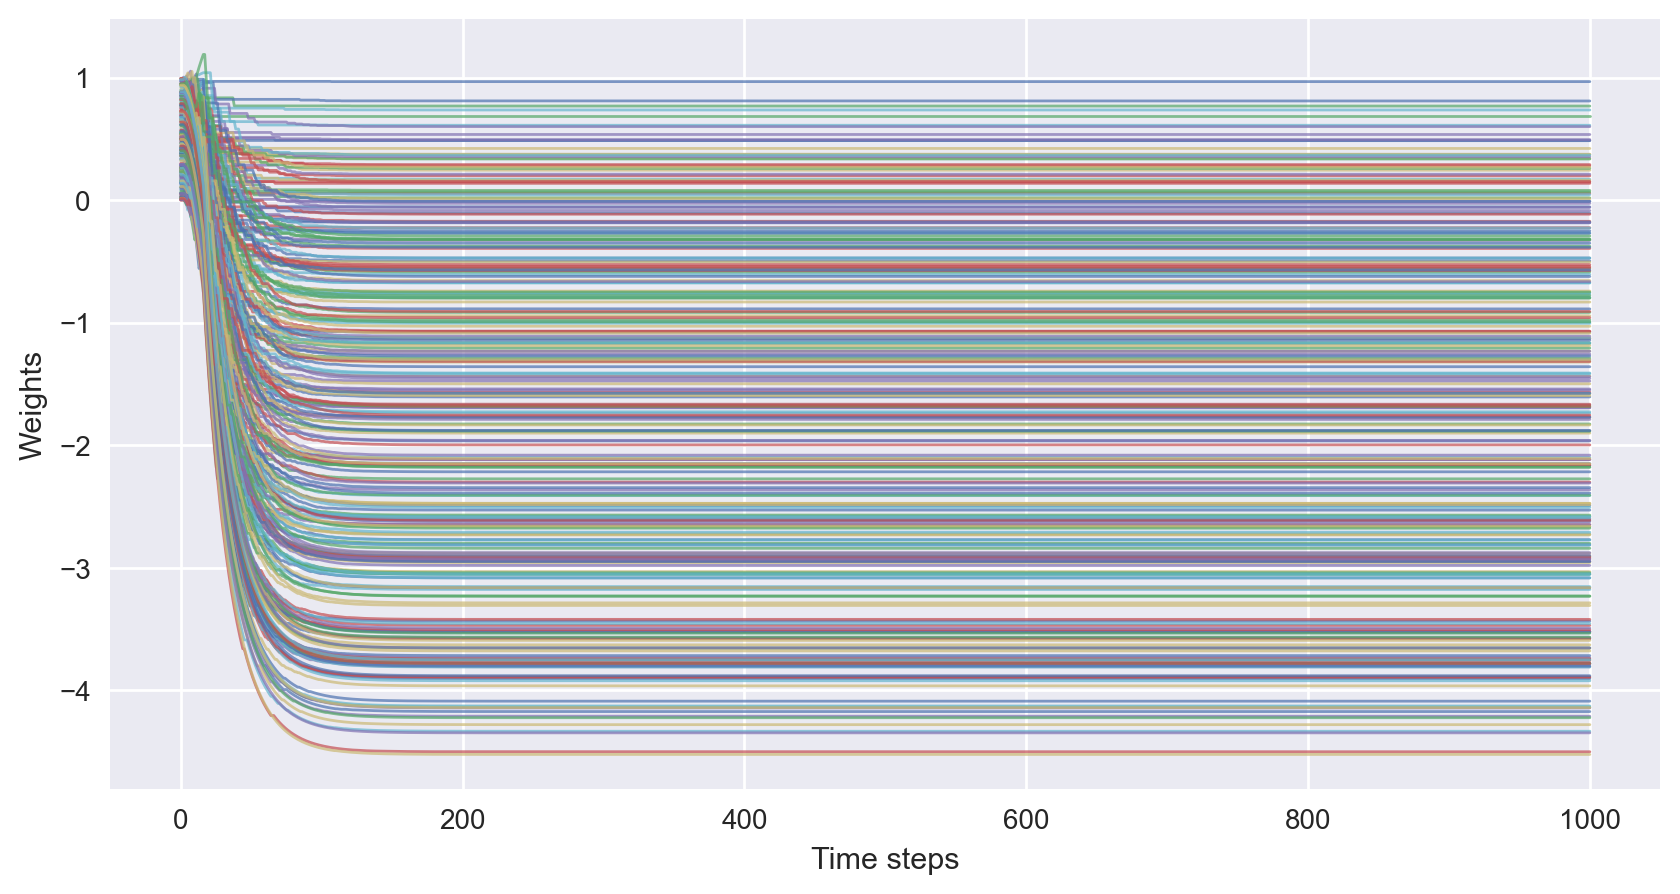

In [58]:
subsampling = 1
plt.figure(figsize=(10, 5))
plt.plot(time_steps[::subsampling], weights_history[::subsampling,0,:], lw=1., alpha=0.7)
plt.xlabel('Time steps')
plt.ylabel('Weights')
plt.show()

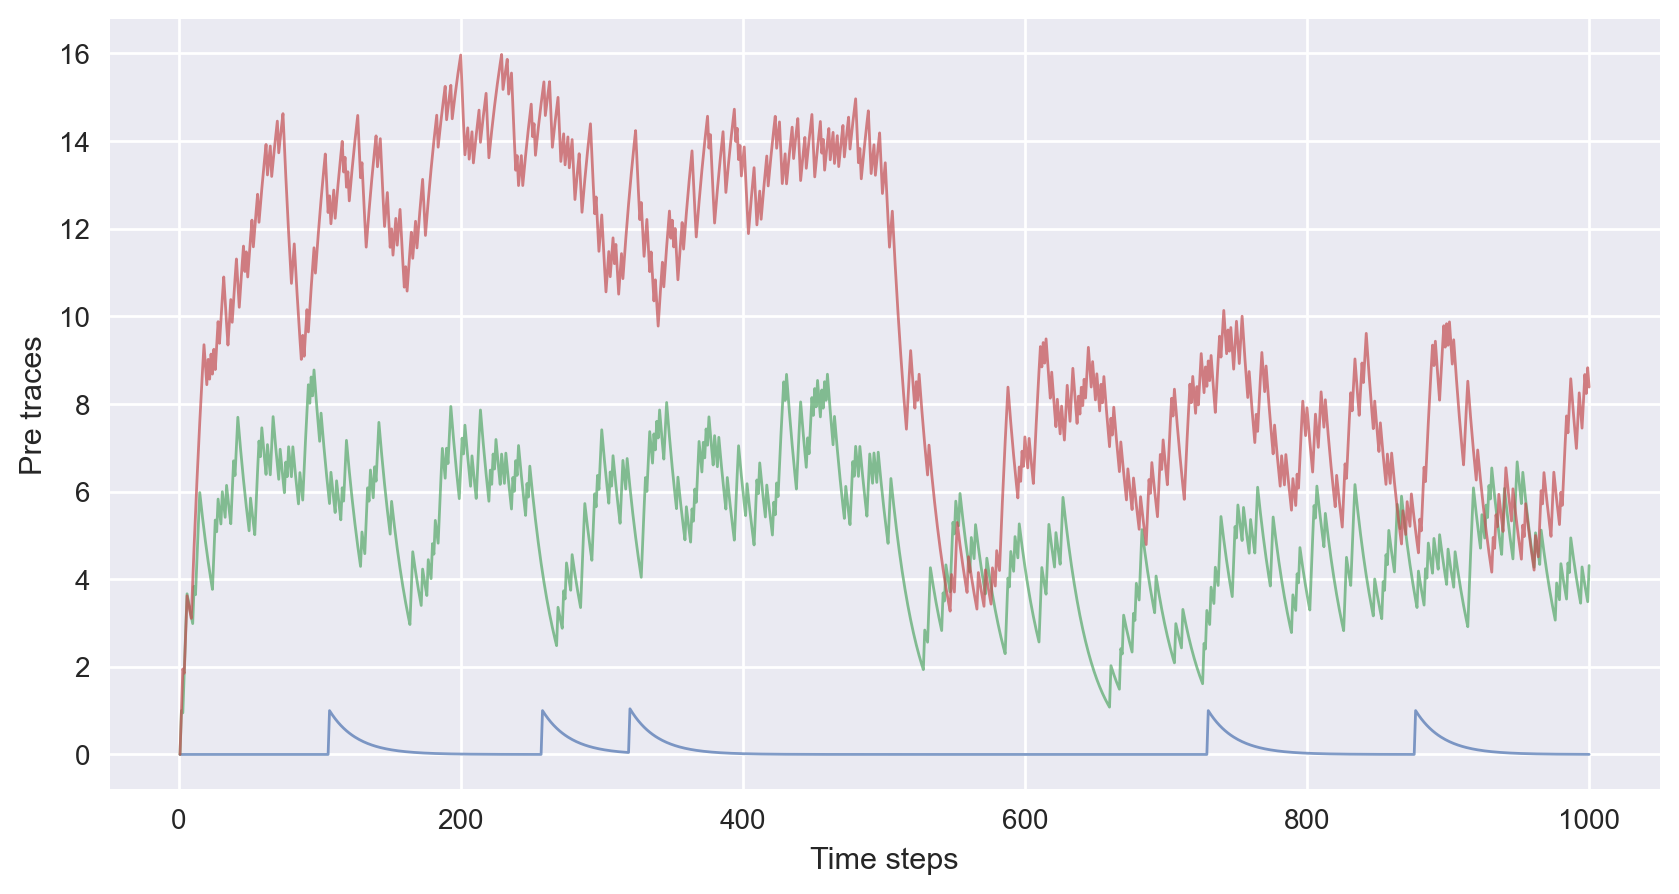

In [59]:
subsampling_time = 1
subsampling_neuron = 100
plt.figure(figsize=(10, 5))
plt.plot(time_steps[1::subsampling_time], pre_trace_record[::subsampling_time,::subsampling_neuron], lw=1., alpha=0.7)
plt.xlabel('Time steps')
plt.ylabel('Pre traces')
plt.show()

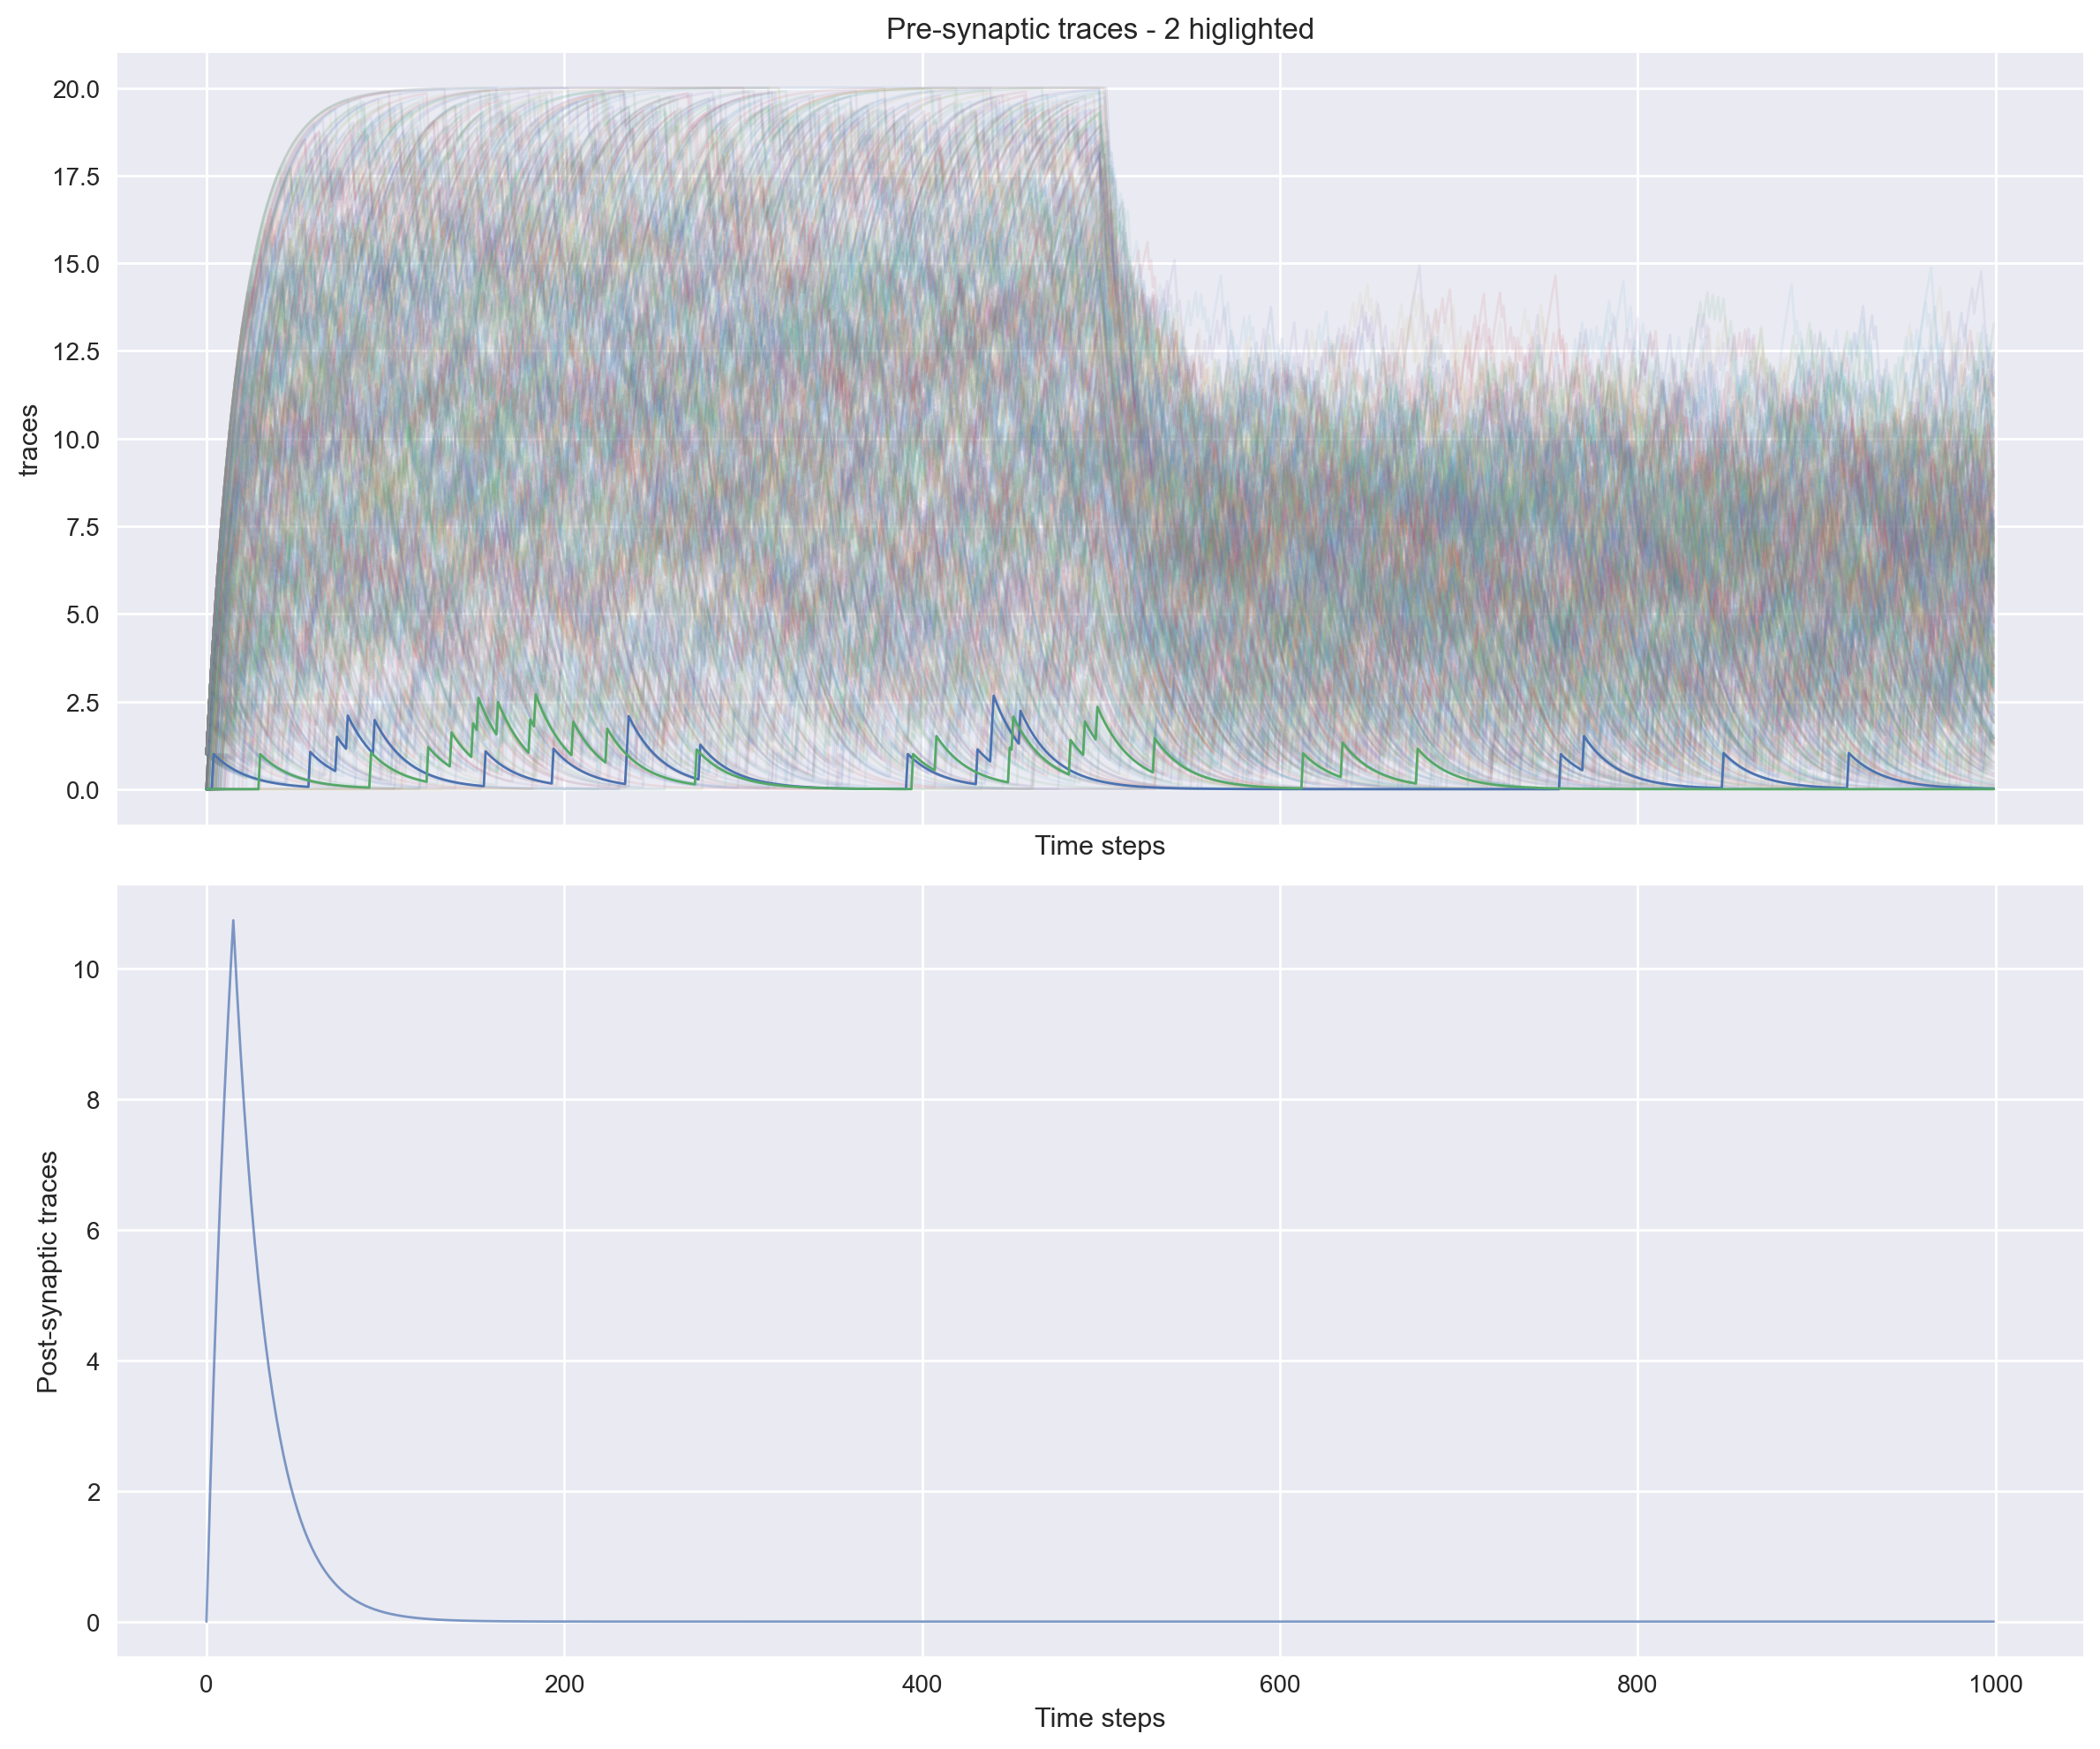

In [68]:
# function to plot pre and post synaptic traces
def plot_traces(pars, pre_trace_record, post_trace_record, trace_index_list = None, time_in_ms = False):
    """
    Plot the pre and post synaptic traces

    INPUT:
    - pars: parameter dictionary
    - pre_trace_record: synaptic traces of the pre-synaptic neurons
    - post_trace_record: synaptic traces of the post-synaptic neurons

    RETURN:
    Interactive demo, Visualization of synaptic traces
    """

    # check if we want the time in ms
    if time_in_ms:
        dt=pars['dt']
        label_x = 'Time (ms)'
    else:
        dt=1
        label_x = 'Time steps'

    # check the index of the trace to higlight
    if trace_index_list is None:
        trace_index_list = [0]
    elif max(trace_index_list) > pre_trace_record.shape[1]:
        print(f'Trace indexes must be less than {pre_trace_record.shape[1]}')
        return
    n = len(trace_index_list)
    
    # useful values
    num_steps = pre_trace_record.shape[0]
    time_steps = np.arange(0, num_steps, 1)*dt

    fig,ax = plt.subplots(2, figsize=(12, 10), sharex=True)

    ax[0].plot(time_steps, pre_trace_record, lw=1., alpha=0.1)
    ax[0].plot(time_steps, pre_trace_record[:,trace_index_list], lw=1., alpha=1)#, color = 'r')
    ax[0].set_title(f'Pre-synaptic traces - {n} higlighted')
    ax[0].set_xlabel(label_x)
    ax[0].set_ylabel('traces')


    ax[1].plot(time_steps, post_trace_record, lw=1., alpha=0.7)
    ax[1].set_xlabel(label_x)
    ax[1].set_ylabel('Post-synaptic traces')

    plt.tight_layout()
    plt.show()


plot_traces(pars, pre_trace_record, post_trace_record, trace_index_list=[10,7])

# Simple Neuron Models

I'll start implementing the neurons as python functions, therefore I'll move to class syntax. 

## LIF neuron

We can see the overall raster plot.

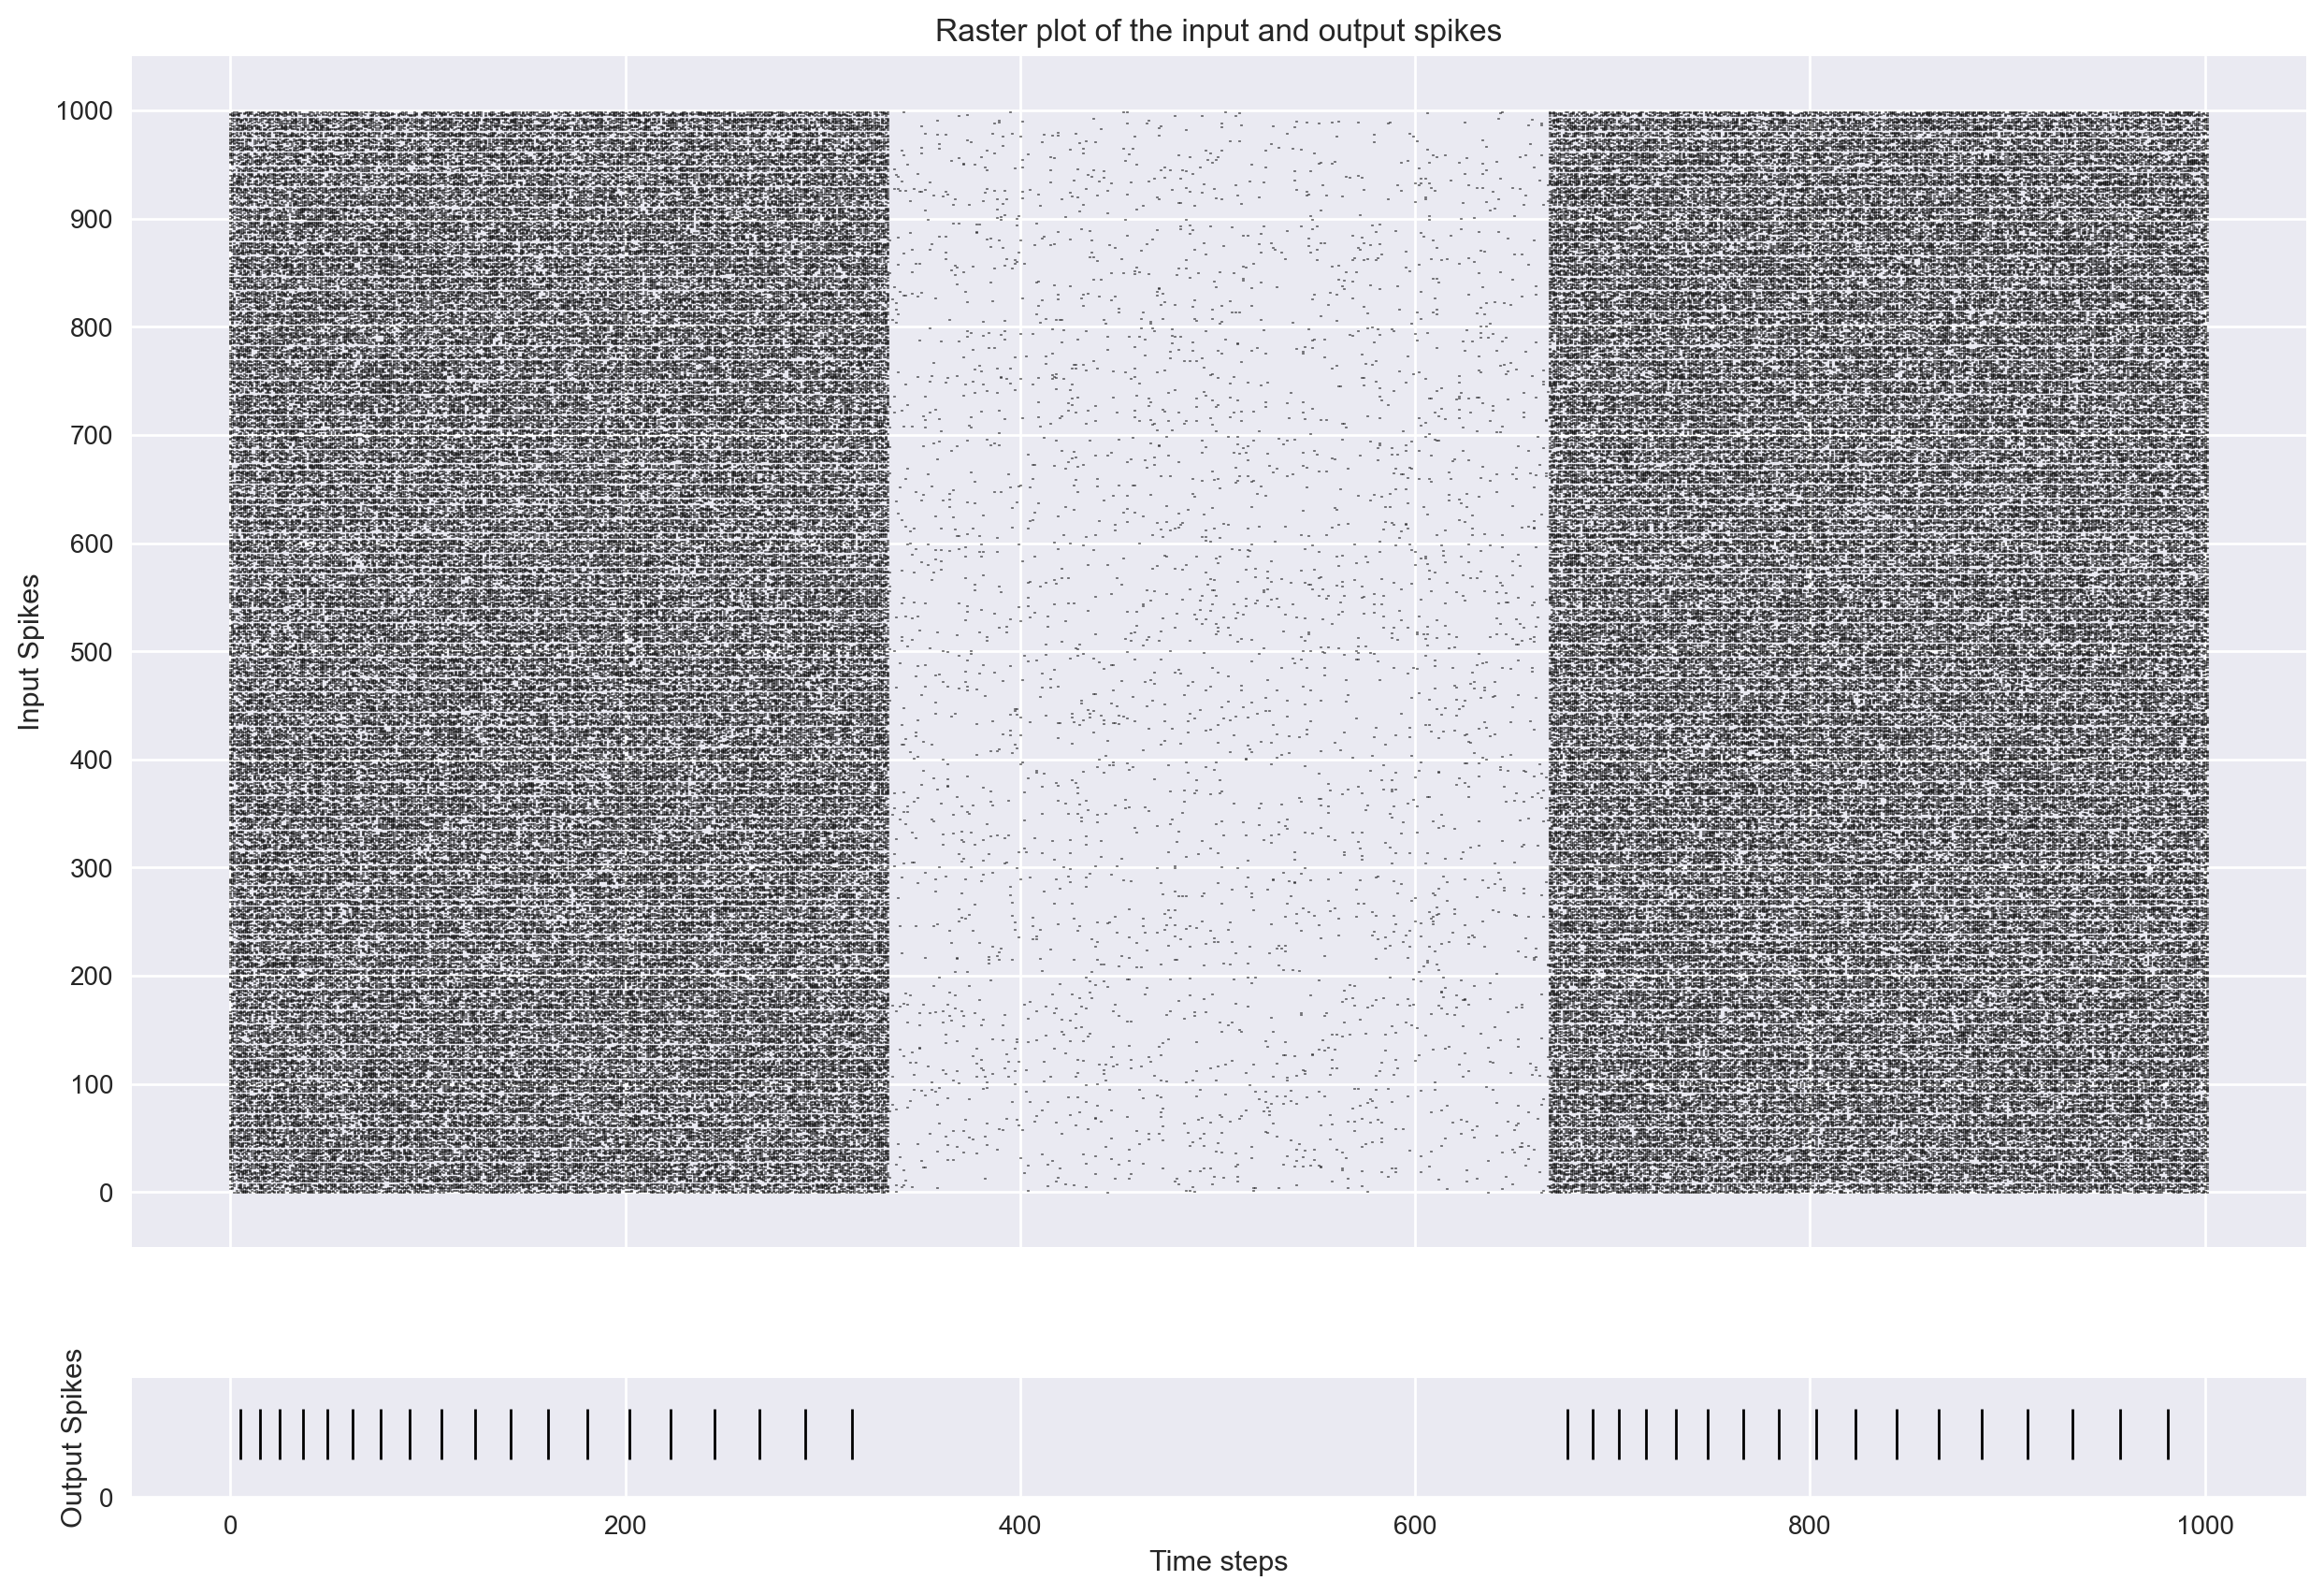

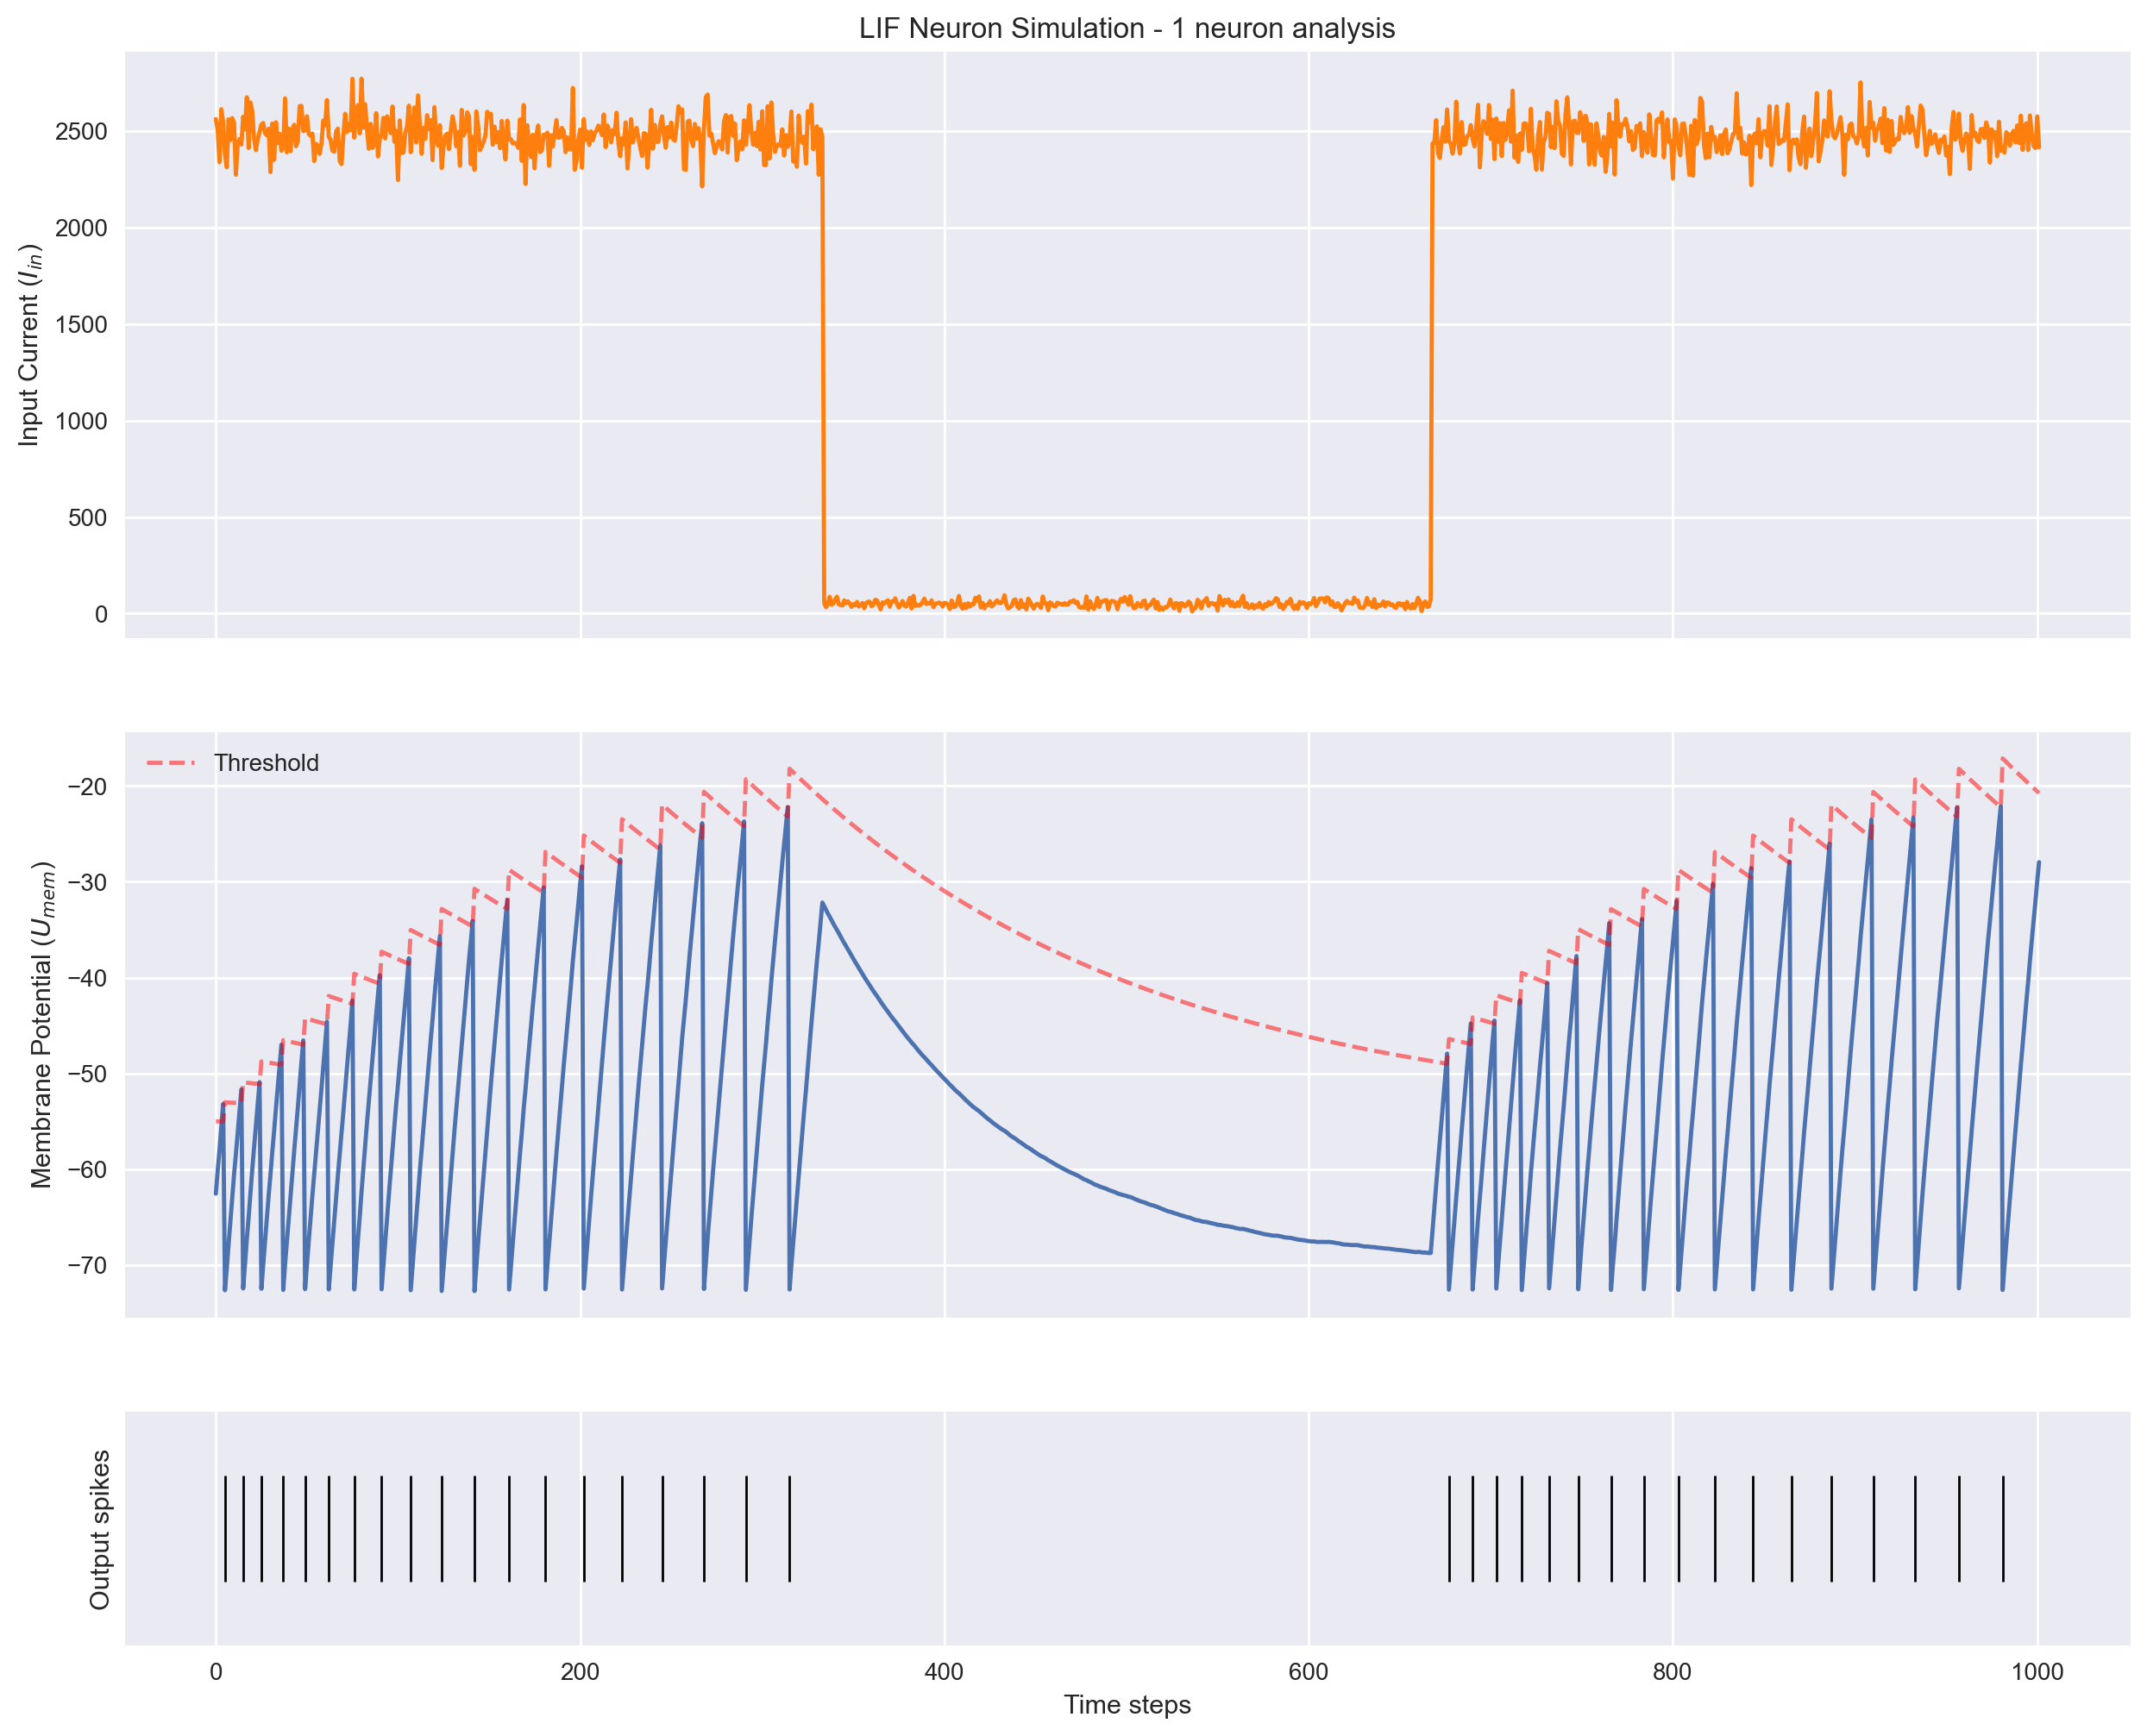

In [61]:
N_pre = 1000
time_steps = 1002 # that is 100 milliseconds
#I = np.ones((time_steps,N_pre))
I = np.concatenate([np.round(np.random.random((time_steps//3,N_pre))), np.round(np.random.random((time_steps//3,N_pre))-0.49),np.round(np.random.random((time_steps//3,N_pre)))], axis=0) 

# random spike train with spike probability 0.5 in the first half and 0.2 in the second half#
pars = default_pars()
#pars = simple_pars(ratio_thr = 1.5, t_ref=5, tau_thr = 40)

# run the base simulation
lif= base_simulation(pars, I, LIFNeuron, N_pre=N_pre, W_init=np.random.random((1,N_pre))*10, 
                        neuron_params = {'refractory_time': False, 'dynamic_threshold': True, 'hard_reset':True})


raster_plot(pars, I, lif.get_records()['spk'], title = 'Raster plot of the input and output spikes')

lif.plot_records(title="LIF Neuron Simulation - 1 neuron analysis")

and also the specific behavior of the output neuron.

## Poisson Neuron Model

First we will need a function to generate Poisson Spike Trains.

In [62]:
def Poisson_generator(pars, rate, n, num_steps, myseed=False, herz_rate = False):
    """Generates poisson trains

    Args:
    pars            : parameter dictionary
    rate            : float or array of shape (n) of spiking rate as prob pre bin or [Hz], constant in time for each spike train 
    n               : number of Poisson trains (N_pre)
    myseed          : random seed. int or boolean

    Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                        there is a spike in ith spike train over time
                        (1 if spike, 0 otherwise)
    """

    # Retrieve simulation parameters
    dt = pars['dt']

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate random variables uniformly distributed in [0,1]
    u_rand = np.random.rand(num_steps, n)

    # check if the rate is in Hz or in probability per bin
    if herz_rate:
        rate_per_bin = rate * (dt / 1000.)
    else:
        rate_per_bin = rate 
    
    # generate Poisson train
    poisson_train = 1. * (u_rand < rate_per_bin)

    return poisson_train


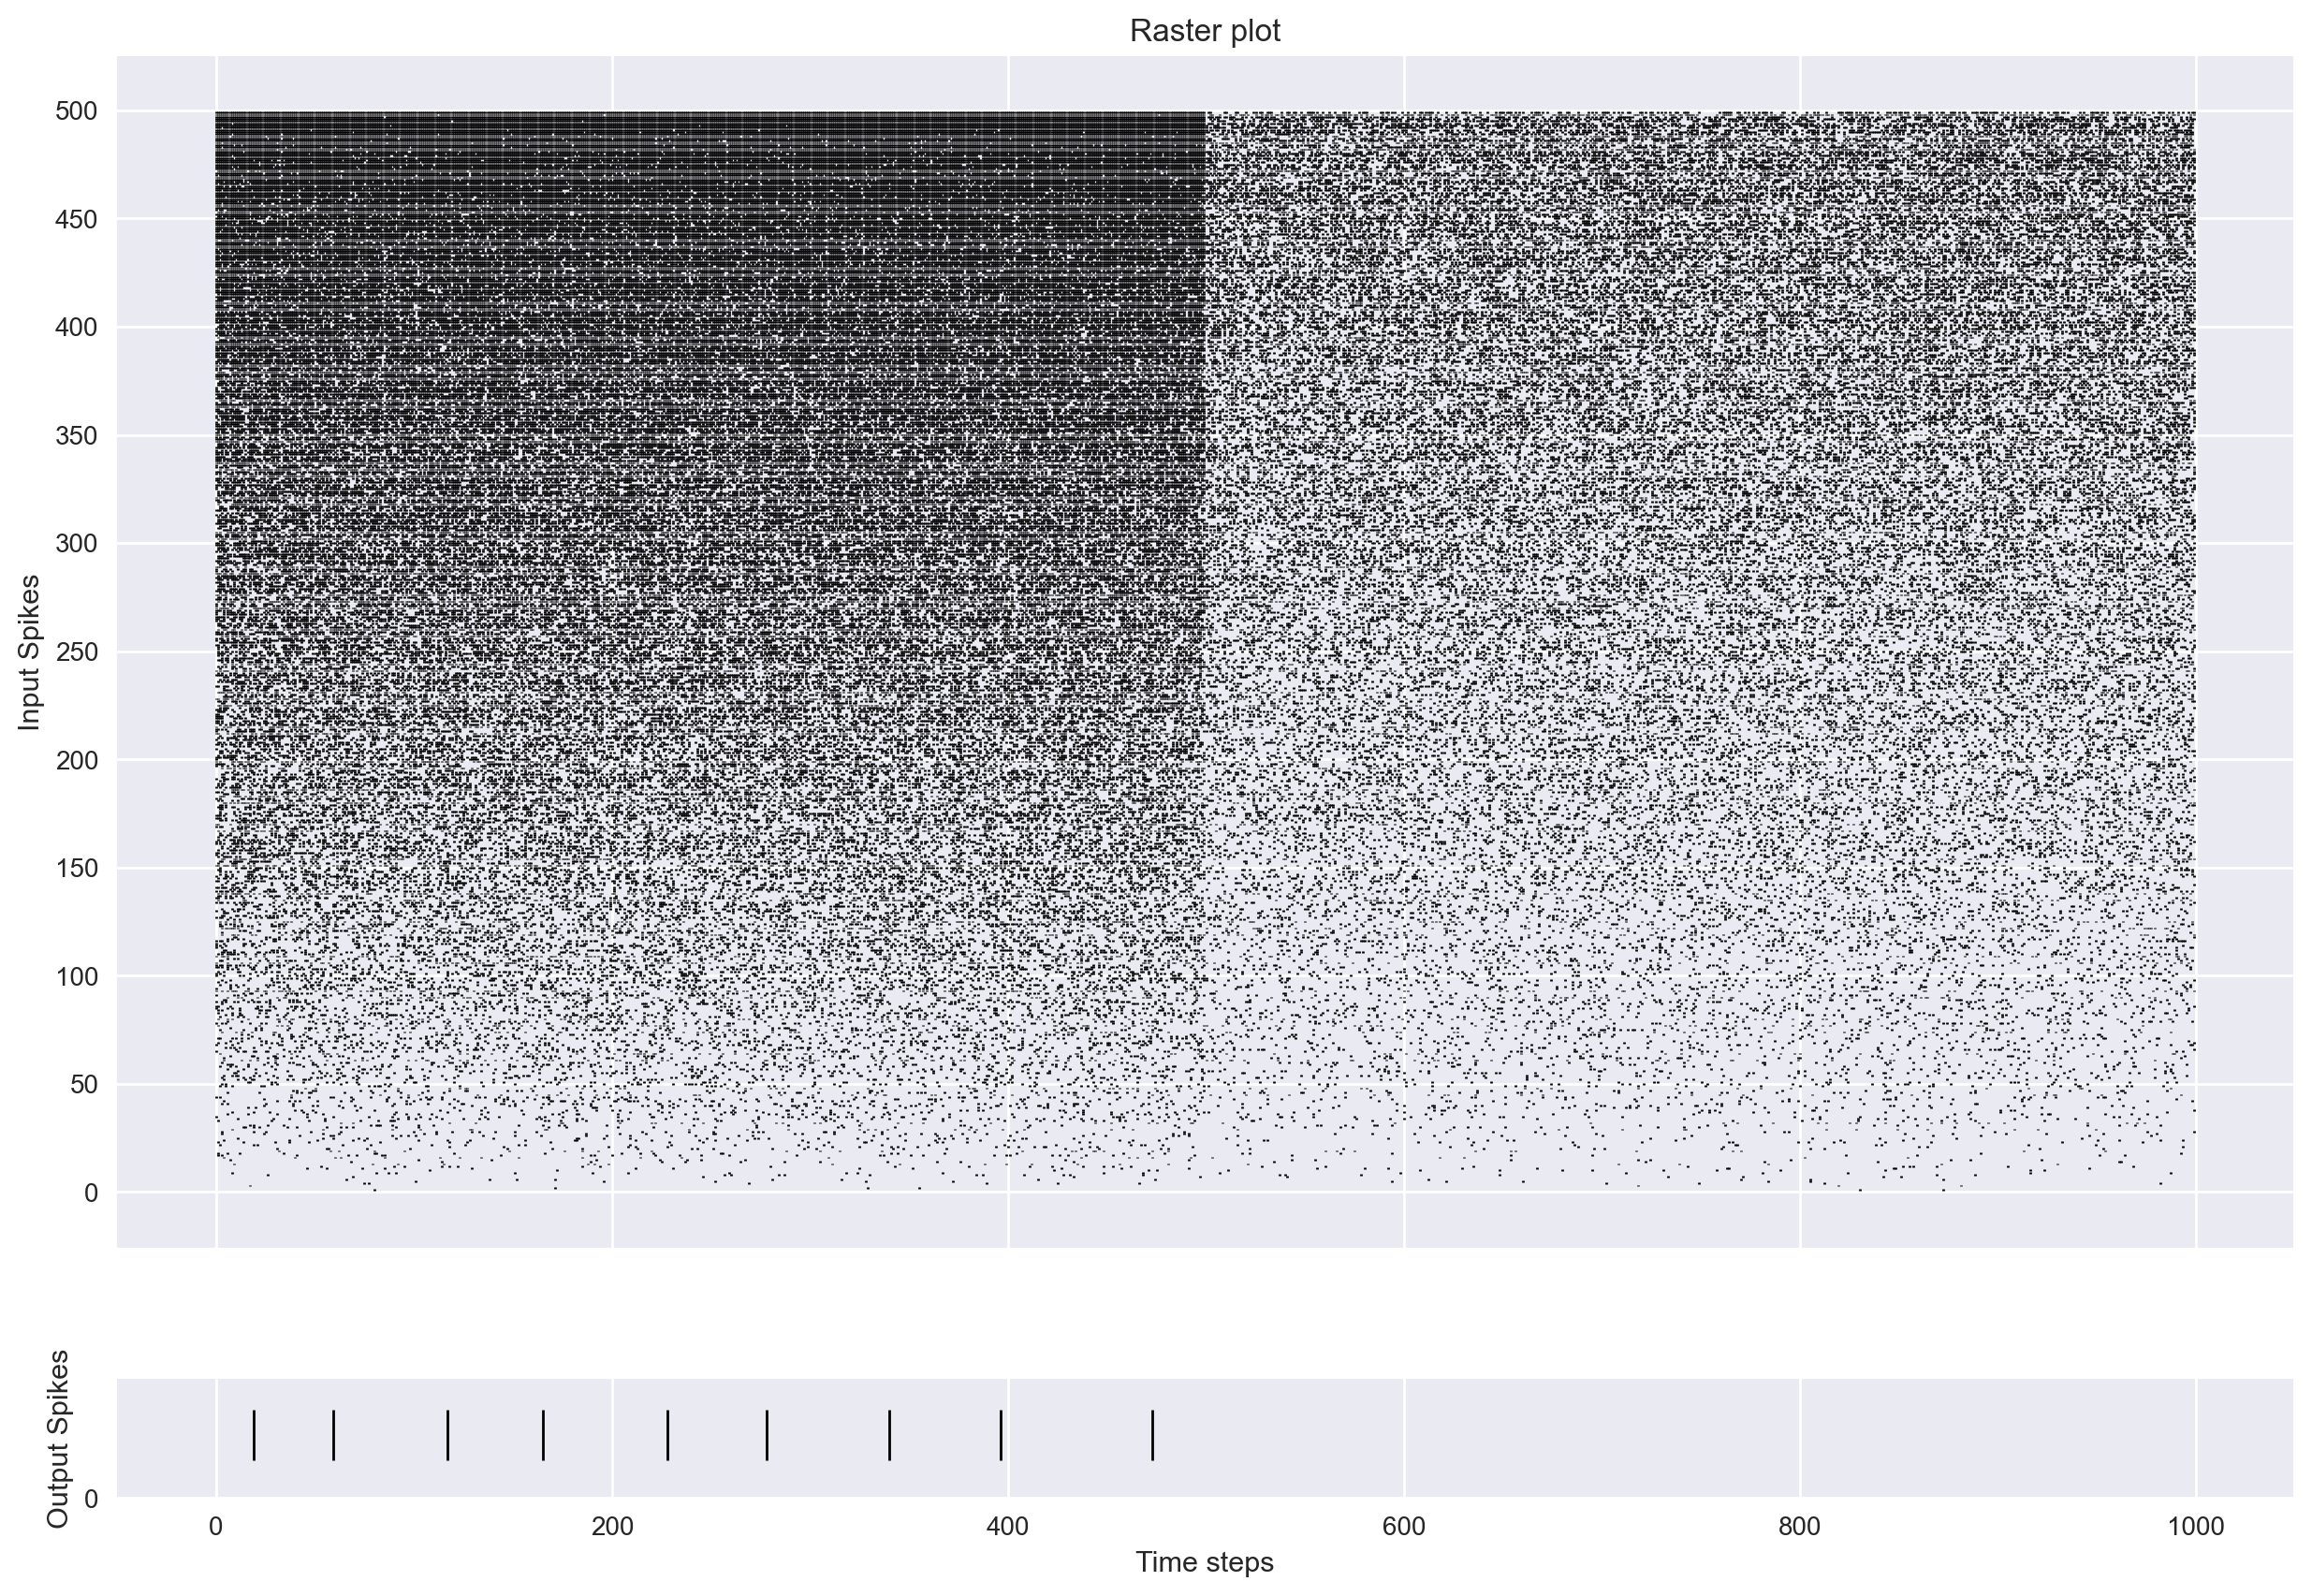

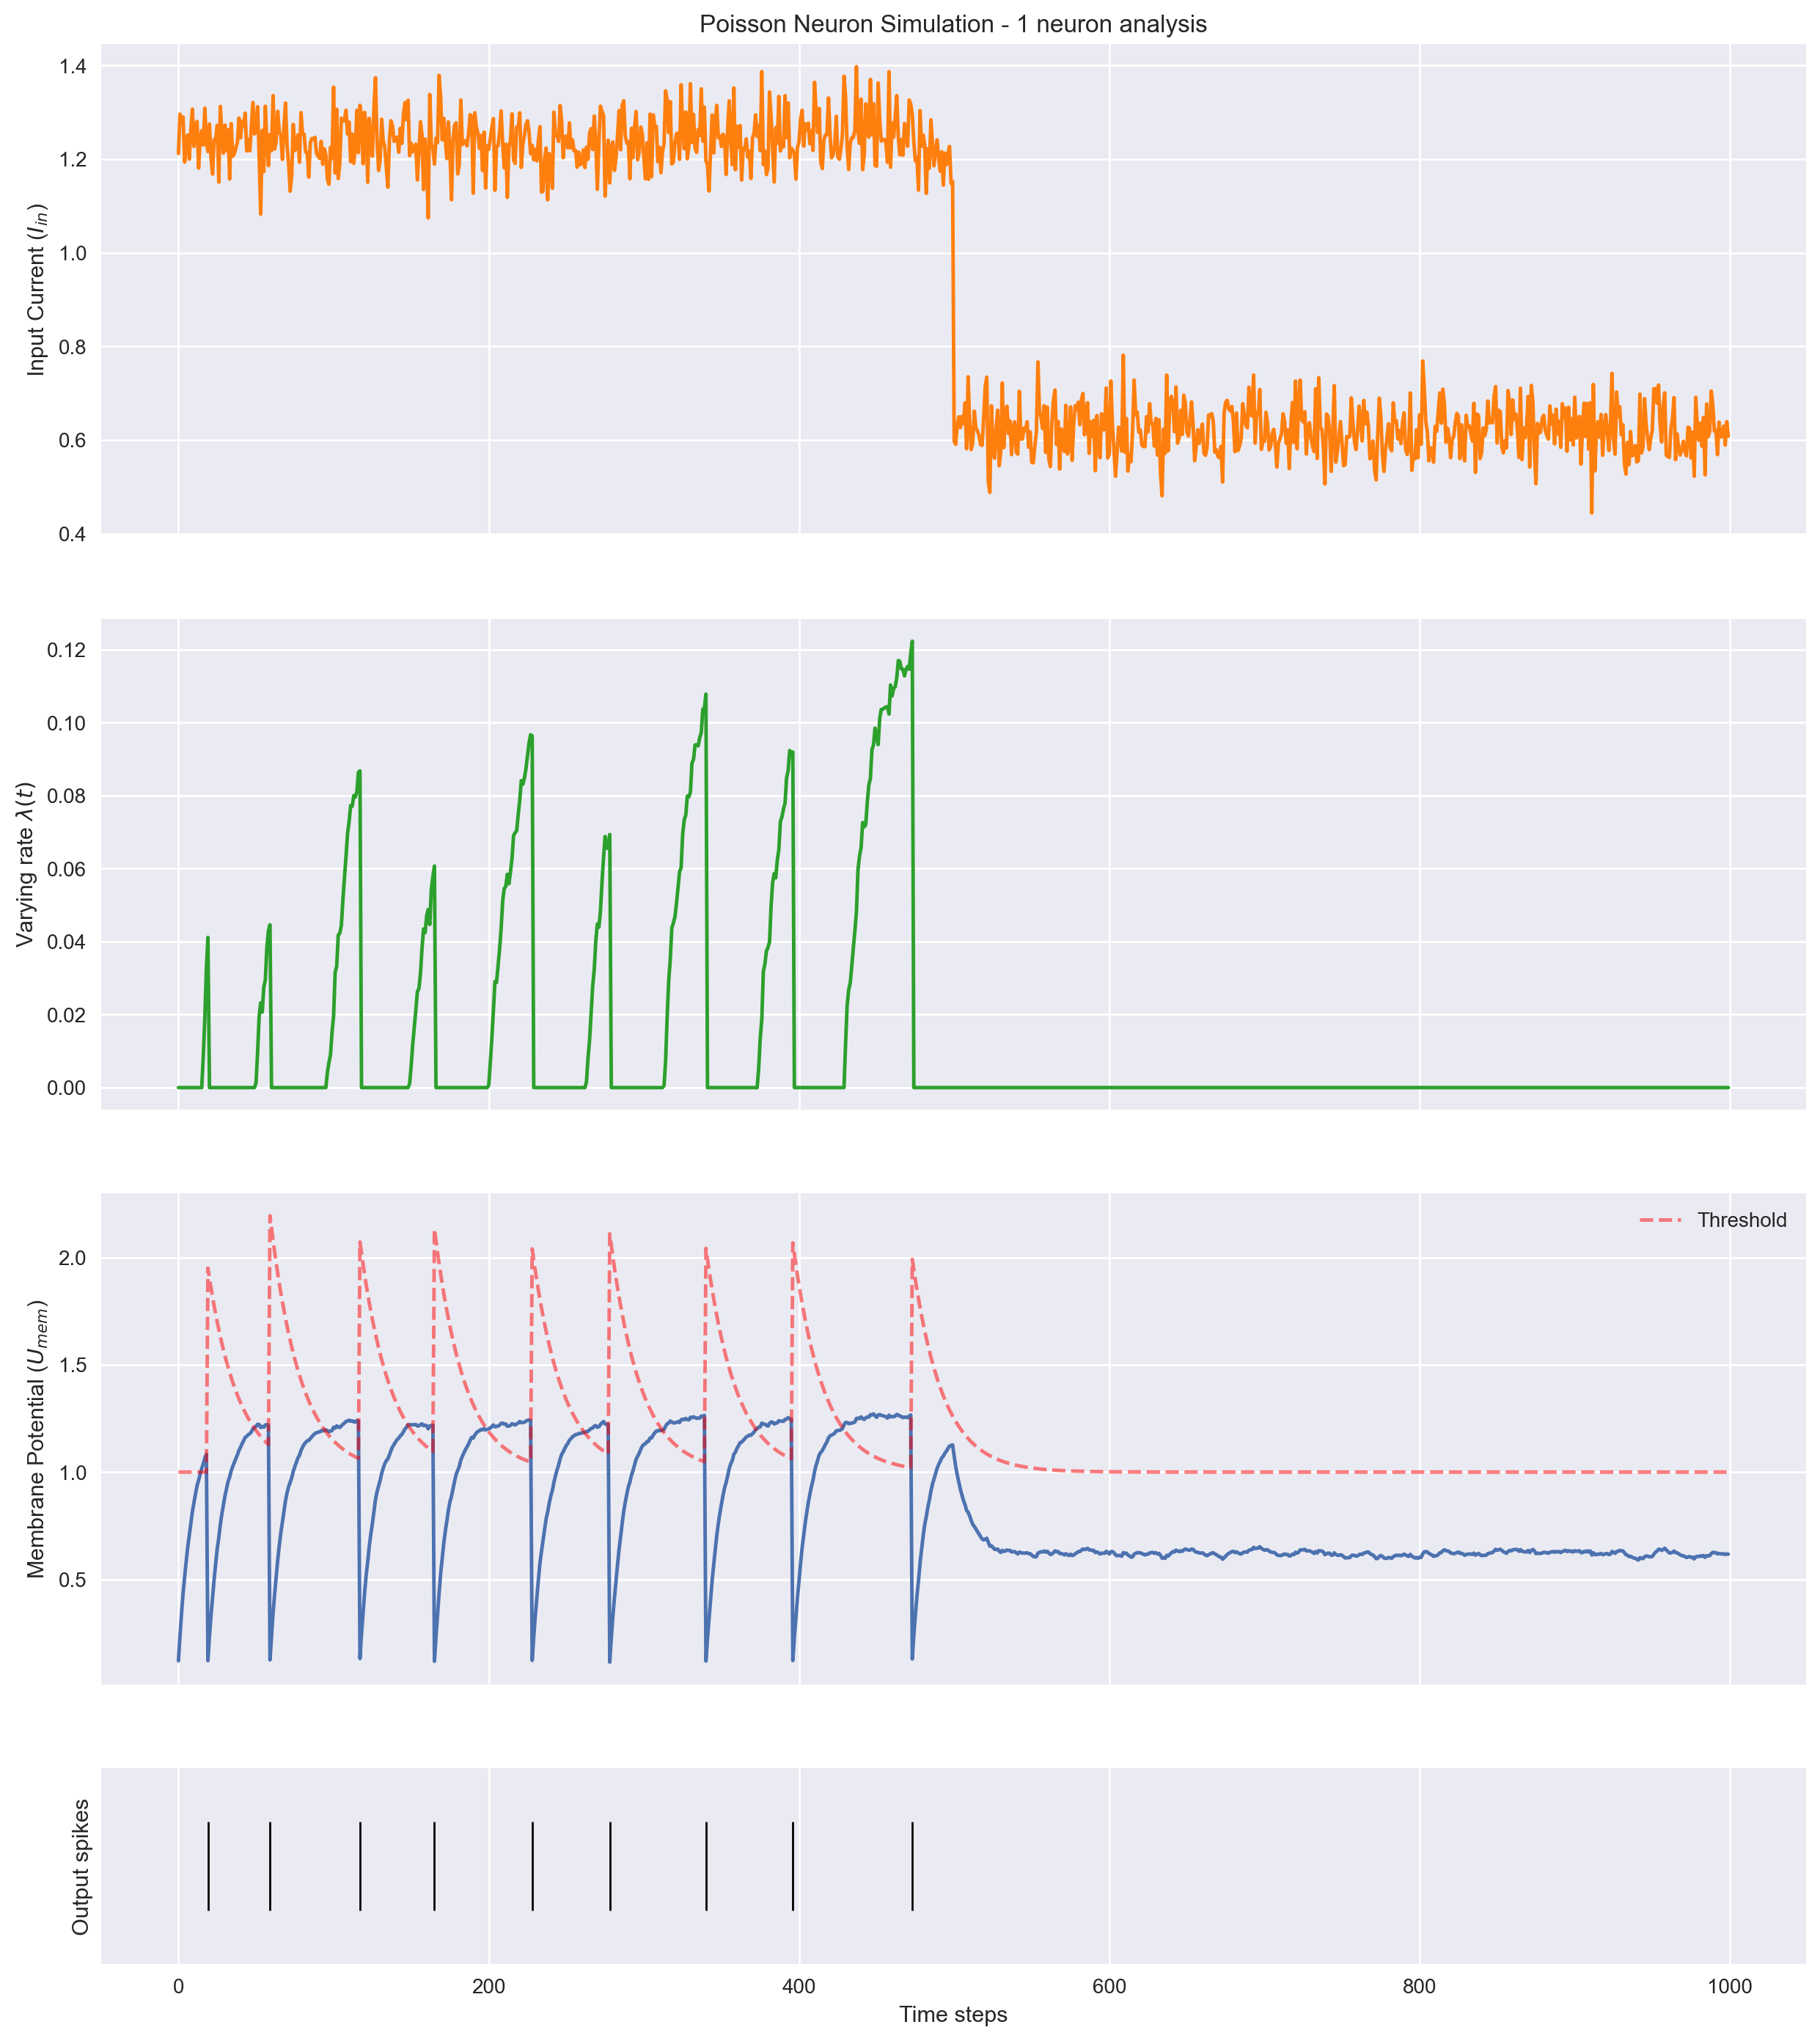

In [63]:
# simple Poisson simulation and plot
N_pre = 500
time_steps = 1000  # that is 100 milliseconds
#pars = default_pars()
pars = simple_pars(alpha = 0.5, t_ref=2, ratio_thr = 2)
rate = np.arange(0,N_pre,1)/N_pre
I = np.concatenate([Poisson_generator(pars, rate = rate, n = N_pre, num_steps = time_steps//2), Poisson_generator(pars, rate = rate/2, n = N_pre, num_steps = time_steps//2)], axis=0) 
# random spike train with spike probability 0.5 in the first half and 0.2 in the second half

poisson = base_simulation(pars, I, PoissonNeuron, N_pre=N_pre, W_init=np.random.random((1,N_pre))*0.01,
                            neuron_params = {'refractory_time': False, 'dynamic_threshold': True, 'hard_reset':True})

raster_plot(s_pars, I, poisson.get_records()['spk'])

poisson.plot_records(title="Poisson Neuron Simulation - 1 neuron analysis")

# Spike time based algorithms

We now can implement the STDP update rule, which relies on the pre and post synaptic traces of the neurons.

In [64]:
# simple Poisson simulation and plot
N_pre = 300
num_steps = 1000  # that is 100 milliseconds
#pars = default_pars()
pars = simple_pars( A_plus = 0.01, A_minus = 0.019, tau_plus = 20, tau_minus = 20, w_max = 10, w_min = 0.001)
rate = np.arange(0,N_pre,1)/N_pre
I = np.concatenate([Poisson_generator(pars, rate = rate, n = N_pre, num_steps = num_steps//2), Poisson_generator(pars, rate = rate/2, n = N_pre, num_steps = num_steps//2)], axis=0)
# simple Poisson simulation and plot
#pars = default_pars()
rate = np.arange(1,N_pre+1,1)/N_pre
I = np.concatenate([Poisson_generator(pars, rate = rate, n = N_pre, num_steps = num_steps//2), Poisson_generator(pars, rate = rate/2, n = N_pre, num_steps = num_steps//2)], axis=0) 
# random spike train with spike probability 0.5 in the first half and 0.2 in the second half
W_init = np.random.random((1,N_pre)) 




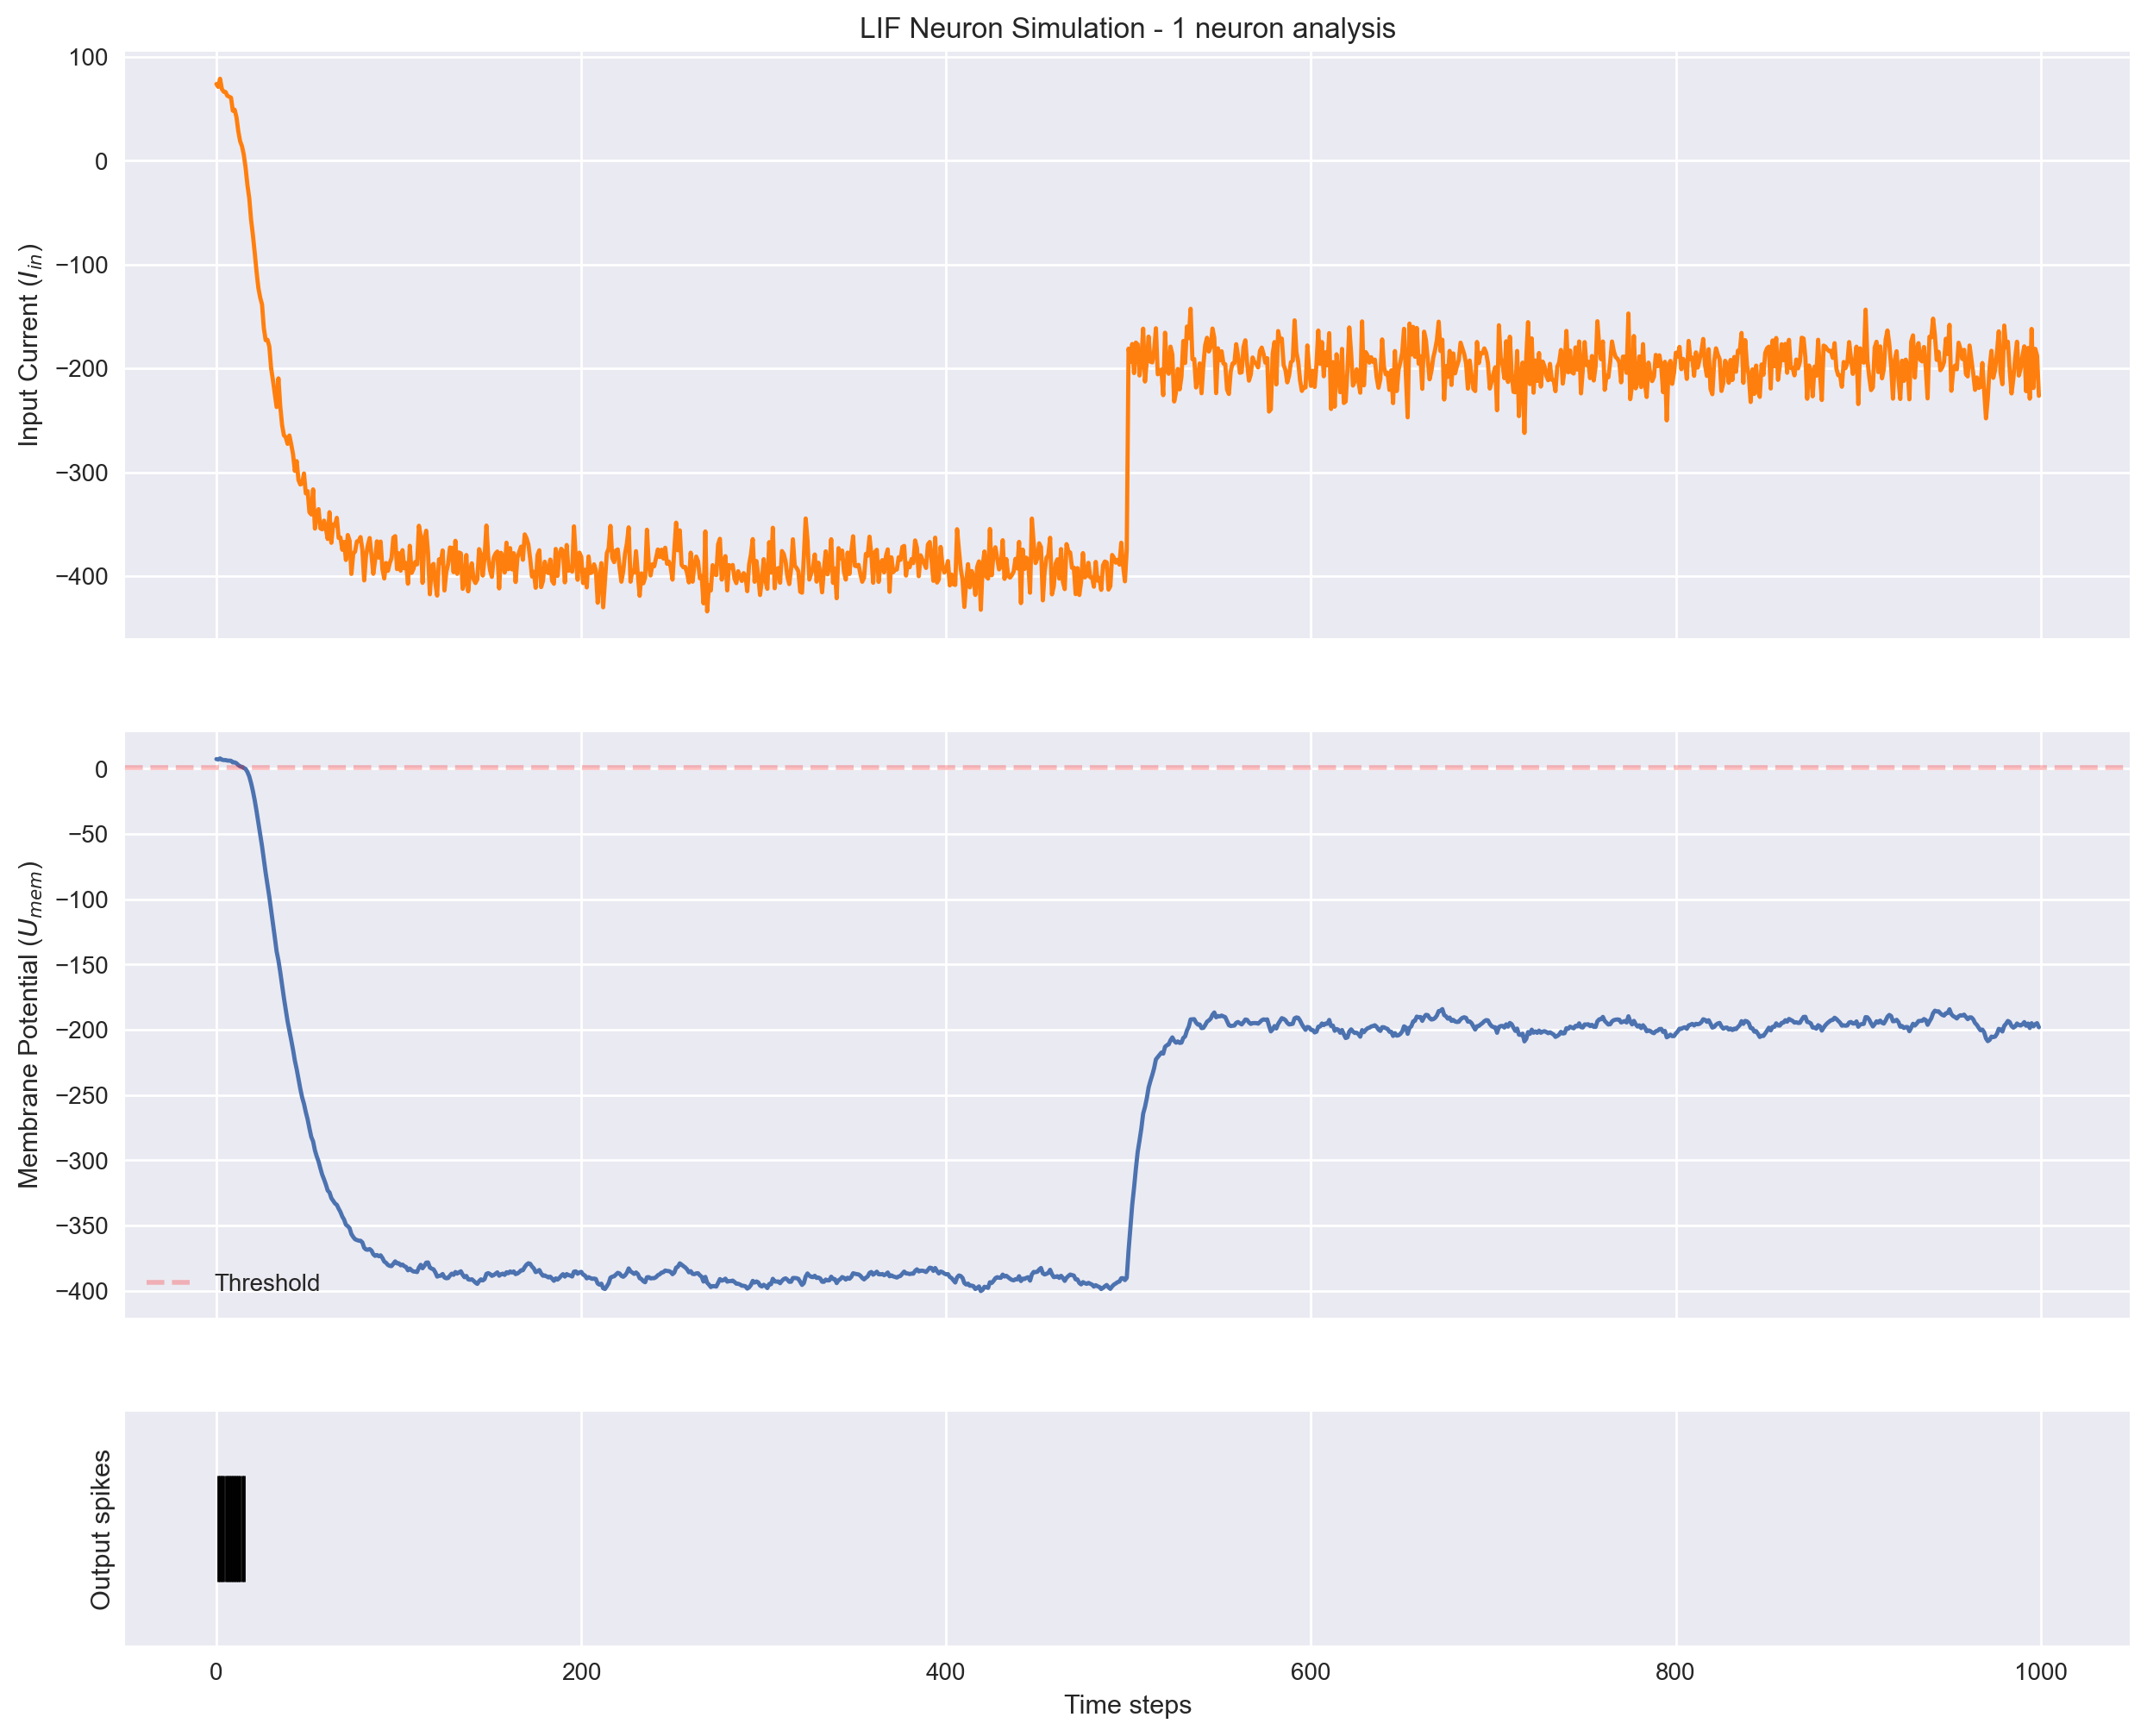

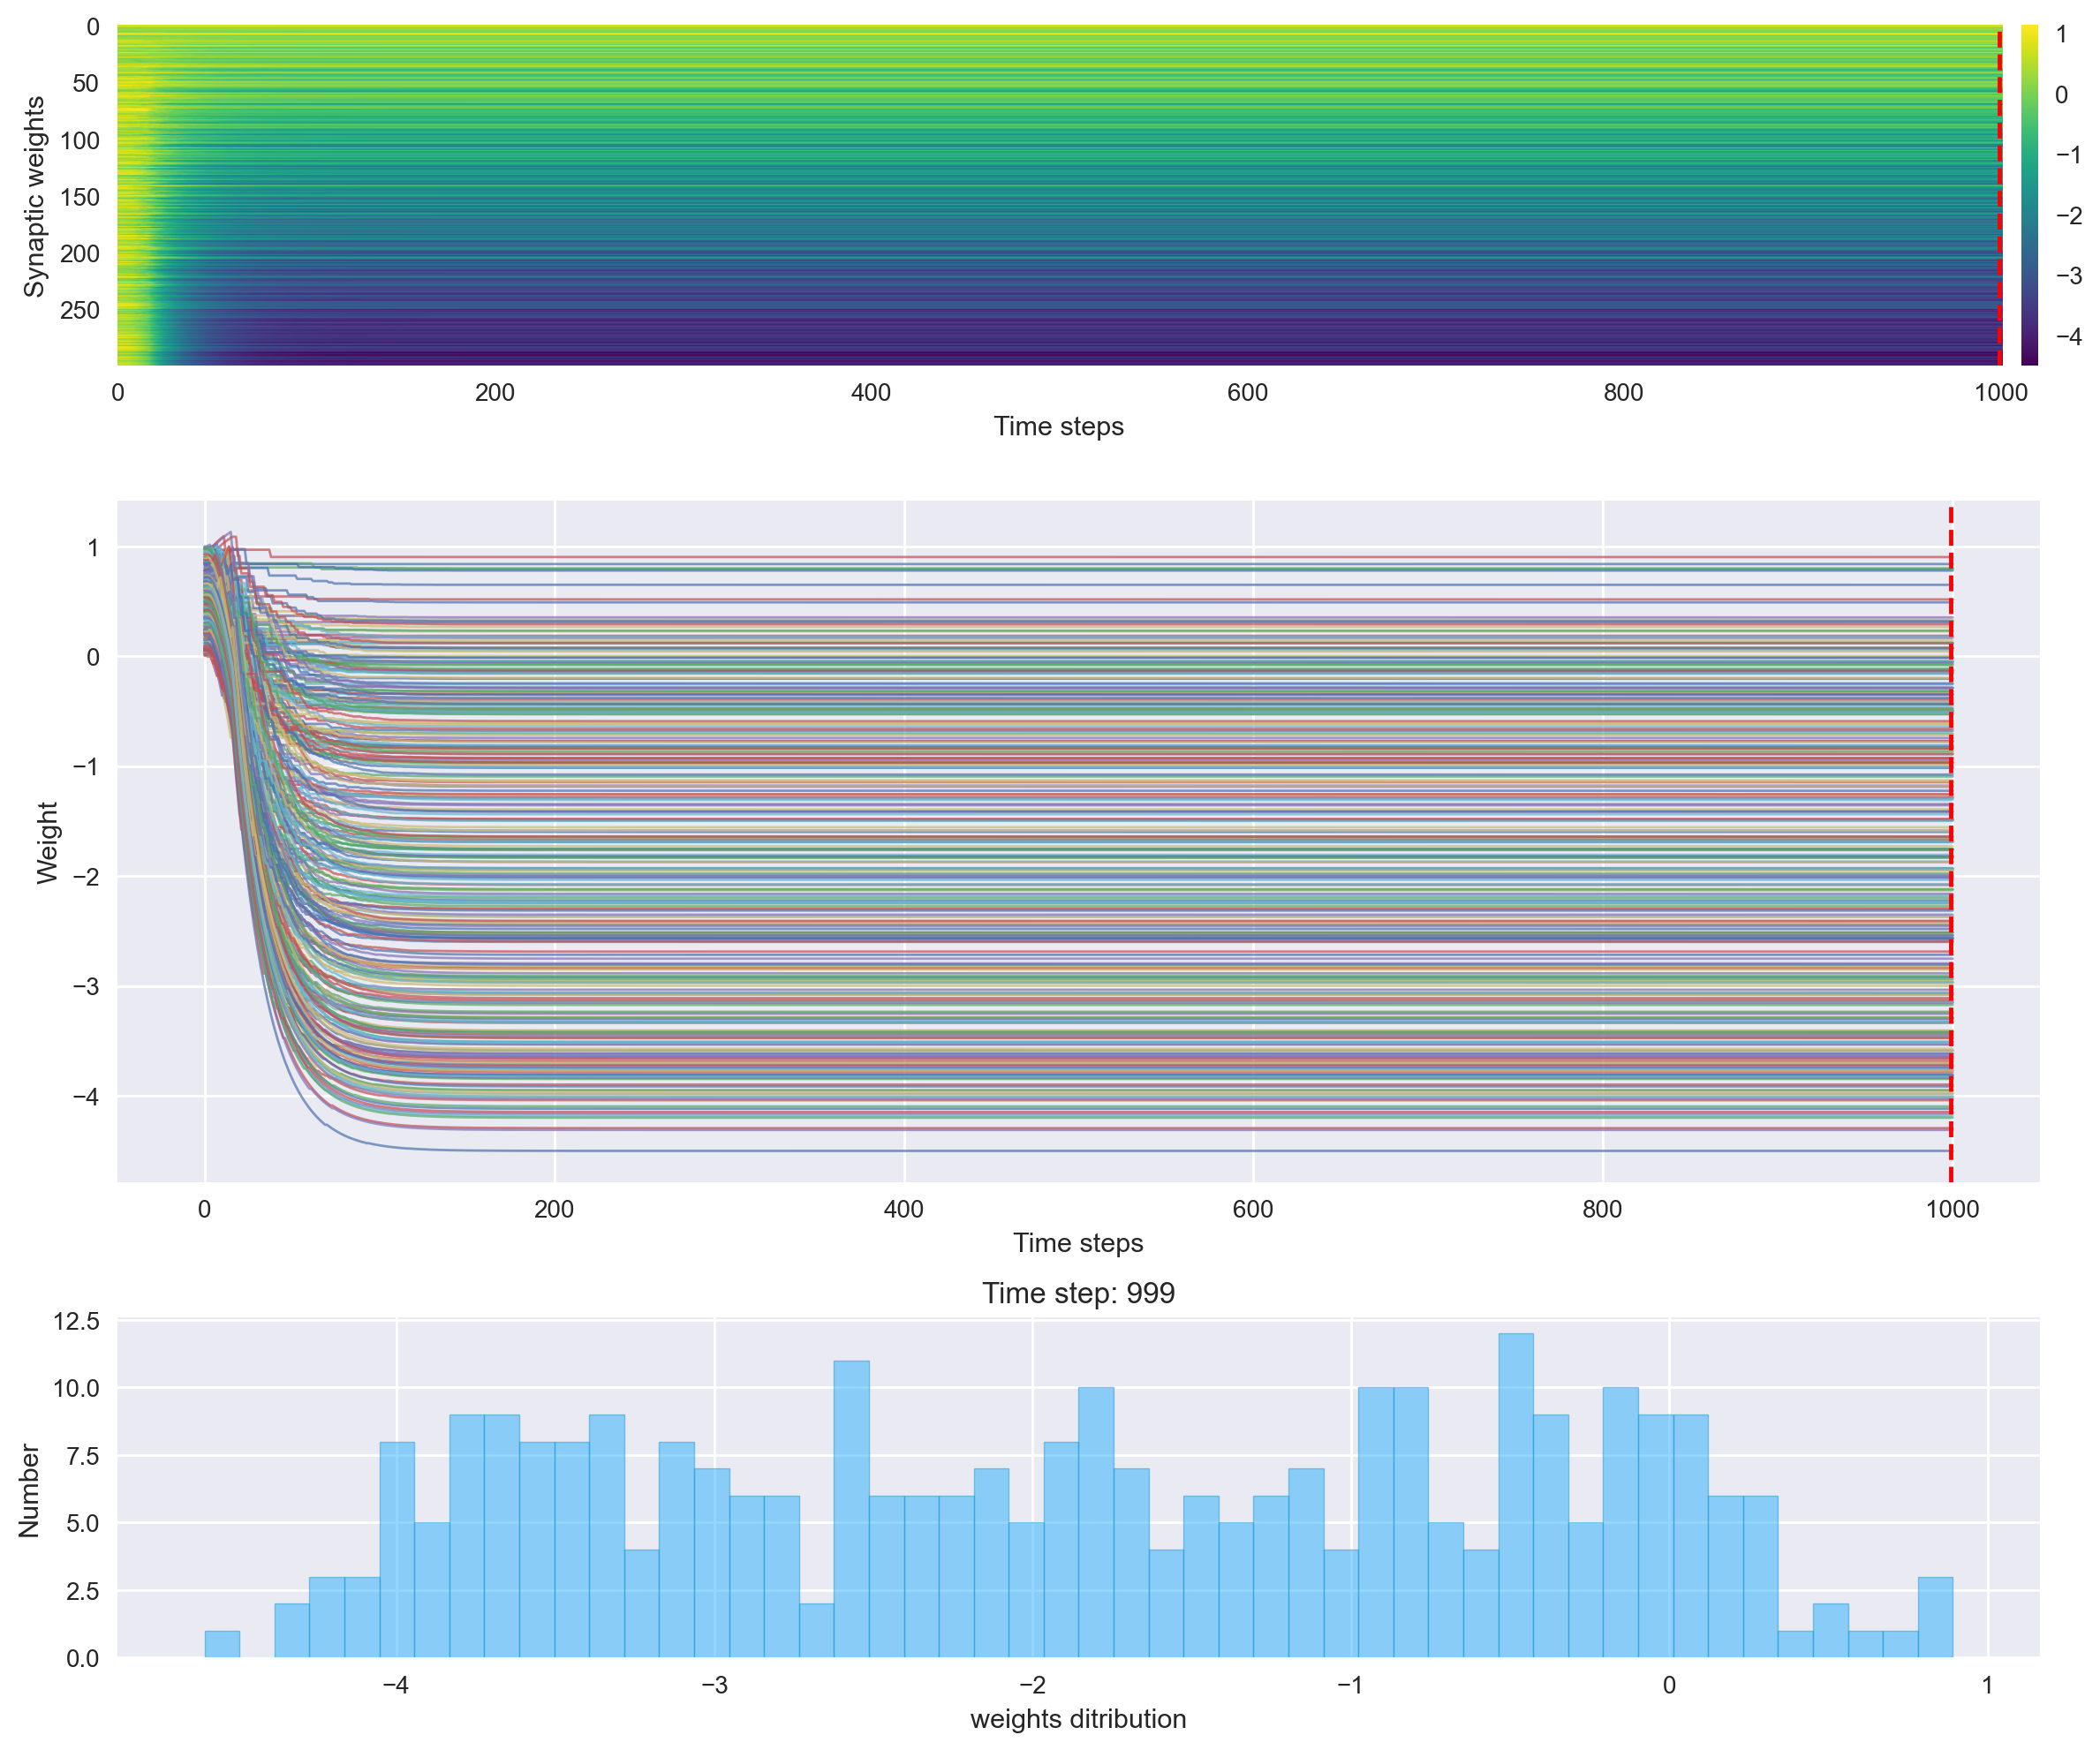

In [65]:
neuron, syn = base_simulation(pars, I, LIFNeuron, N_pre=N_pre, W_init=W_init, weight_rule = STDP_synapse, 
                            neuron_params = {'refractory_time': False, 'dynamic_threshold': False, 'hard_reset':True},
                            weight_update_params= {'short_memory_trace':False, 'hard_constrain':'None'})
#raster_plot(s_pars, I, neuron.get_records()['spk'], title = 'Raster plot of the input and output spikes')

neuron.plot_records(title="LIF Neuron Simulation - 1 neuron analysis")

weights_plot(pars, syn.get_records()['W'][:,0,:],time_step = num_steps-1)

In [66]:

widgets.interact(weights_plot, 
                 pars = fixed(pars),
                 weights_history=fixed(weights_history[:,0,:]),
                 time_step=widgets.IntSlider(
                     value = 0, 
                     min=0, 
                     max=num_steps, 
                     step=num_steps//100,
                     description = 'Time step',
                     layout=my_layout),
                 )


#weigths_plot(1000,weights_history=weights_history[:,0,:])

interactive(children=(IntSlider(value=0, description='Time step', layout=Layout(width='620px'), max=1000, step…

<function __main__.weights_plot(pars, weights_history, time_step=None, time_in_ms=False)>